In [2]:
import sys; sys.path.append("../../")
from DataPreprocessing.DataPreprocessing import *
from DataExploration import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.stem import SnowballStemmer

# Question:
    For some specific game of multiple versions, Does rating get better or worse over time?




## 1- Expectations:   
        Newer versions have better ratings

## 2- Data Collection: 
    

## Read data 

In [3]:
df = read_data(kind='dataset')


In [4]:
df = df[['Name', 'Platform', 'Year_of_Release', 'Publisher', 
         'Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Score', 
         'User_Count', 'Rating']]
df.head()

,Name,Platform,Year_of_Release,Publisher,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii Sports,Wii,2006.0,Nintendo,82.53,76.0,51.0,8,322.0,E
1,Super Mario Bros.,NES,1985.0,Nintendo,40.24,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Nintendo,35.52,82.0,73.0,8.3,709.0,E
3,Wii Sports Resort,Wii,2009.0,Nintendo,32.77,80.0,73.0,8,192.0,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Nintendo,31.37,NaN,NaN,NaN,NaN,NaN


In [5]:
# print type of each column
print(df.dtypes)


Name                object
Platform            object
Year_of_Release    float64
Publisher           object
Global_Sales       float64
Critic_Score       float64
Critic_Count       float64
User_Score          object
User_Count         float64
Rating              object
dtype: object


In [6]:
# User_Score is string so we need to convert it to float with ignoring 'tbd' values
df['User_Score'] = df['User_Score'].replace('tbd', np.nan)
df['User_Score'] = df['User_Score'].astype(float)


In [7]:
# divide Critic Score by 10 to be in the same scale as User Score
df['Critic_Score'] = df['Critic_Score']/10


## Handle Missing Values

In [8]:
# df =handle_missing_values(df, handling_method='mode_knn')
df = handle_missing_values(df, handling_method='drop')
df.head()

Total Number of rows : 16719
Number of rows with missing values: 9894
Number of rows after dropping: 6825
Number of rows after handling missing values: 6825 and Number of missing values: 0


,Name,Platform,Year_of_Release,Publisher,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii Sports,Wii,2006.0,Nintendo,82.53,7.6,51.0,8.0,322.0,E
2,Mario Kart Wii,Wii,2008.0,Nintendo,35.52,8.2,73.0,8.3,709.0,E
3,Wii Sports Resort,Wii,2009.0,Nintendo,32.77,8.0,73.0,8.0,192.0,E
6,New Super Mario Bros.,DS,2006.0,Nintendo,29.80,8.9,65.0,8.5,431.0,E
7,Wii Play,Wii,2006.0,Nintendo,28.92,5.8,41.0,6.6,129.0,E


# try grouping different versions for one publisher (Nintendo)

In [9]:
df_g = df.groupby('Publisher')
len(df_g)

262

In [10]:
for i, ( _, g) in enumerate(df_g):
    if g['Publisher'].iloc[0] == 'Nintendo':
        print(i)

160


In [11]:
# print type of User_Score
print(type(df['User_Score'].iloc[0]))
# type of Year_of_Release
print(type(df['Year_of_Release'].iloc[0]))



<class 'numpy.float64'>
<class 'numpy.float64'>


In [12]:
nintendo = df_g.get_group('Nintendo')
nintendo.head()

,Name,Platform,Year_of_Release,Publisher,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii Sports,Wii,2006.0,Nintendo,82.53,7.6,51.0,8.0,322.0,E
2,Mario Kart Wii,Wii,2008.0,Nintendo,35.52,8.2,73.0,8.3,709.0,E
3,Wii Sports Resort,Wii,2009.0,Nintendo,32.77,8.0,73.0,8.0,192.0,E
6,New Super Mario Bros.,DS,2006.0,Nintendo,29.80,8.9,65.0,8.5,431.0,E
7,Wii Play,Wii,2006.0,Nintendo,28.92,5.8,41.0,6.6,129.0,E


In [13]:
stemmer = SnowballStemmer('english')

In [14]:
# substitute special characters with empty string
reg = re.compile(r'[!@#$%^&*(),.?":{}|<>;]')
reg.sub('', 'hello!@#$%^&*() world:; 1234')


'hello world 1234'

In [15]:
pd.Series(nintendo['Name'].map(lambda x: stemmer.stem(reg.sub('', x).lower())))

0                                wii sport
2                           mario kart wii
3                        wii sports resort
6                      new super mario bro
7                                 wii play
                       ...                
13215        metroid prime federation forc
14295                      electroplankton
16424    mario vs donkey kong tipping star
16514              art academy home studio
16656                     fast racing neo 
Name: Name, Length: 291, dtype: object

In [16]:
# maybe remove ['new', 'super', 'wii', ...]. seems bad though

In [17]:
tmp1 = nintendo['Name'].str.split(' ').str.get(0)
tmp1 = tmp1.map(lambda x: stemmer.stem(reg.sub('', x).lower()))
nintendo_games = nintendo.groupby(pd.Series(tmp1))
for _, g in nintendo_games:
    print(g['Name'].head()) # three versions of the same game
    break

2919                         Advance Wars
3105    Advance Wars 2: Black Hole Rising
4937            Advance Wars: Dual Strike
Name: Name, dtype: object


In [18]:
min_year = df['Year_of_Release'].min()
max_year = df['Year_of_Release'].max()
print(min_year, max_year)

1985.0 2016.0


In [19]:
# sorted by year will add column for each game's ratings
df_year_rate = pd.DataFrame(df['Year_of_Release'].unique(), columns=['Year_of_Release'])
df_year_rate = df_year_rate.sort_values(by='Year_of_Release')
# set index to year
df_year_rate = df_year_rate.set_index('Year_of_Release')

# the same for critics
df_year_rate_critics = pd.DataFrame(df['Year_of_Release'].unique(), columns=['Year_of_Release'])
df_year_rate_critics = df_year_rate_critics.sort_values(by='Year_of_Release')
df_year_rate_critics = df_year_rate_critics.set_index('Year_of_Release')

print(df_year_rate)
print(df_year_rate_critics)

Empty DataFrame
Columns: []
Index: [1985.0, 1988.0, 1992.0, 1994.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0]
Empty DataFrame
Columns: []
Index: [1985.0, 1988.0, 1992.0, 1994.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0]


In [20]:
import warnings

warnings.filterwarnings('ignore')
# TODO group by platform?
d_users = dict() # key: name of first version of the game, value: list of (ratings, year)
d_critics = dict() # key: name of first version of the game, value: list of (ratings, year)


# groups of publishers
for group_name, group in df_g:

    # group by normalized name (Kirby's, Kirby, Kirby:) are the same
    tmp1 = group['Name'].str.split(' ').str.get(0)
    tmp1 = tmp1.map(lambda x: stemmer.stem(reg.sub('', x).lower()))
    games_groups = group.groupby(pd.Series(tmp1))

    # same game, different platforms and years
    for _, g in games_groups:
        # sort by Platfrom
        g = g.sort_values(by=['Platform'])
        # sort by Year
        g = g.sort_values(by=['Year_of_Release']) 
        # keep unique Name in the dataframe
        g = g.drop_duplicates(subset=['Name'])
        # key: name of first version of the game, value: list of ratings
        d_users[g['Name'].iloc[0]] = g['User_Score'].tolist(), g['Year_of_Release'].tolist()
        d_critics[g['Name'].iloc[0]] = g['Critic_Score'].tolist(), g['Year_of_Release'].tolist()

        # add column for each game's ratings, missing: NaN, existing: from g['User_Score']
        df_year_rate[g['Name'].iloc[0]] = np.nan
        df_year_rate.loc[g['Year_of_Release'], g['Name'].iloc[0]] = g['User_Score'].tolist()

        df_year_rate_critics[g['Name'].iloc[0]] = np.nan
        df_year_rate_critics.loc[g['Year_of_Release'], g['Name'].iloc[0]] = g['Critic_Score'].tolist()
        

# print(d_users)
# print(d_critics)

# print(df_year_rate)
warnings.filterwarnings('default')


In [21]:
# sort df_year_rate columns games having most ratings
df_year_rate2 = df_year_rate.reindex(df_year_rate.count().sort_values(ascending=False).index, axis=1)
df_year_rate_critics2 = df_year_rate_critics.reindex(df_year_rate_critics.count().sort_values(ascending=False).index, axis=1)
df_year_rate2


,FIFA 2001 Major League Soccer,Madden NFL 2001,NHL 2001,The Sims: Livin Large,Mario Kart: Super Circuit,Tom Clancy's Ghost Recon,NBA Live 2001,Sonic Adventure 2,NCAA Football 2002,MLB 2002,...,Agatha Christie: The ABC Murders,Suzuki TT Superbikes,FunkMaster Flex's Digital Hitz Factory,World Championship Pool 2004,Pulse Racer,Puchi Puchi Virus,NightCaster II: Equinox,Karnaaj Rally,Goblin Commander: Unleash the Horde,RACE On
Year_of_Release,,,,,,,,,,,,,,,,,,,,,
1985.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000.0,7.8,7.7,7.7,7.9,NaN,NaN,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
θ = 10 # threshold for number of versions of the game
σ = 5 # number of subplots in a row


In [23]:
print(len(d_users)) # number of games

2381


In [24]:
df_year_rate2['Year_of_Release'] = df_year_rate2.index
# make it first column
cols = df_year_rate2.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_year_rate2 = df_year_rate2[cols]
df_year_rate2 = df_year_rate2.reset_index(drop=True)

df_year_rate_critics2['Year_of_Release'] = df_year_rate_critics2.index
# make it first column
cols = df_year_rate_critics2.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_year_rate_critics2 = df_year_rate_critics2[cols]
df_year_rate_critics2 = df_year_rate_critics2.reset_index(drop=True)

df_year_rate2

/tmp/ipykernel_9296/2153380001.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_year_rate2['Year_of_Release'] = df_year_rate2.index
/tmp/ipykernel_9296/2153380001.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_year_rate_critics2['Year_of_Release'] = df_year_rate_critics2.index


,Year_of_Release,FIFA 2001 Major League Soccer,Madden NFL 2001,NHL 2001,The Sims: Livin Large,Mario Kart: Super Circuit,Tom Clancy's Ghost Recon,NBA Live 2001,Sonic Adventure 2,NCAA Football 2002,...,Agatha Christie: The ABC Murders,Suzuki TT Superbikes,FunkMaster Flex's Digital Hitz Factory,World Championship Pool 2004,Pulse Racer,Puchi Puchi Virus,NightCaster II: Equinox,Karnaaj Rally,Goblin Commander: Unleash the Horde,RACE On
0,1985.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1988.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1992.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1994.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1996.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1997.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1998.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2000.0,7.8,7.7,7.7,7.9,NaN,NaN,8.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2001.0,5.8,7.9,8.8,7.9,8.3,NaN,8.8,8.3,8.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# choose games that appear in at least θ years (not NaN in at least θ years)
df_year_rate3 = df_year_rate2.loc[:, df_year_rate2.count() >= θ]
df_year_rate_critics3 = df_year_rate_critics2.loc[:, df_year_rate_critics2.count() >= θ]
print(df_year_rate3.shape)
df_year_rate3

(25, 33)


,Year_of_Release,FIFA 2001 Major League Soccer,Madden NFL 2001,NHL 2001,The Sims: Livin Large,Mario Kart: Super Circuit,Tom Clancy's Ghost Recon,NBA Live 2001,Sonic Adventure 2,NCAA Football 2002,...,NASCAR 2001,Halo: Combat Evolved,Castlevania: Symphony of the Night,The Legend of Alon D'ar,Assassin's Creed,Super Mario Advance,Star Wars: Super Bombad Racing,Naruto: Ultimate Ninja 2,Battlefield 1942,The Legend of Zelda: A Link to the Past
0,1985.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1988.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1992.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1994.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1996.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1997.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,9.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1998.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2000.0,7.8,7.7,7.7,7.9,NaN,NaN,8.0,NaN,NaN,...,6.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2001.0,5.8,7.9,8.8,7.9,8.3,NaN,8.8,8.3,8.7,...,6.9,8.6,8.5,6.7,NaN,9.1,8.6,NaN,NaN,NaN


In [26]:
def plot_heatmap_melted(df_hh, minimum=0, maximum=10, label='Rating', exp=False):
    df_hh = df_hh.copy()
    if exp:
        df_hh.iloc[:,1:] = np.exp(df_hh.iloc[:,1:])
        df_hh.iloc[:,1:] = maximum * df_hh.iloc[:,1:] / df_hh.iloc[:,1:].max(axis=0)
        df_hh.iloc[:,1:] = df_hh.iloc[:,1:].round(2)
    # count of games having more than θ versions
    count = 0
    for i in range(len(df_hh.columns)):
        if df_hh.iloc[:,i].count() >= θ:
            count += 1
    print(count)
    

    # Reshape the DataFrame so that each game is in its own row
    df_melted = df_hh.melt(id_vars='Year_of_Release', var_name='Game', value_name=label)

    # Set up the plot using Seaborn
    sns.set_style('white')
    plt.figure(figsize=(10, 6))

    # Create the heatmap using Seaborn
    # heatmap = sns.heatmap(df_melted.pivot(index='Game', columns='Year_of_Release', values='Rating'), cmap='RdYlGn', linewidths=0.5, cbar_kws={'label': 'Rating'}, vmin=minimum, vmax=maximum)
    heatmap = sns.heatmap(df_melted.pivot(index='Game', columns='Year_of_Release', values=label), cmap='RdYlGn', linewidths=0.5, cbar_kws={'label': label}, vmin=minimum, vmax=maximum)
    
    # Adjust the labels and ticks
    heatmap.invert_yaxis()
    # plt.yticks(rotation=0, ha='left')
    plt.yticks(rotation=0)
    plt.xlabel('Year_of_Release')

    # Add a title
    if exp:
        plt.title('Heatmap of Game Ratings by Year taken exp')
    else:
        plt.title('Heatmap of Game Ratings by Year')

    # Show the plot
    plt.show()

In [27]:
# take first λ games
λ = 5 # number of games to show
df_year_rate4 = df_year_rate3.iloc[:,:λ+1].copy()
# take years from 2000 to 2016
df_year_rate4 = df_year_rate4.loc[df_year_rate4['Year_of_Release'] >= 2000]

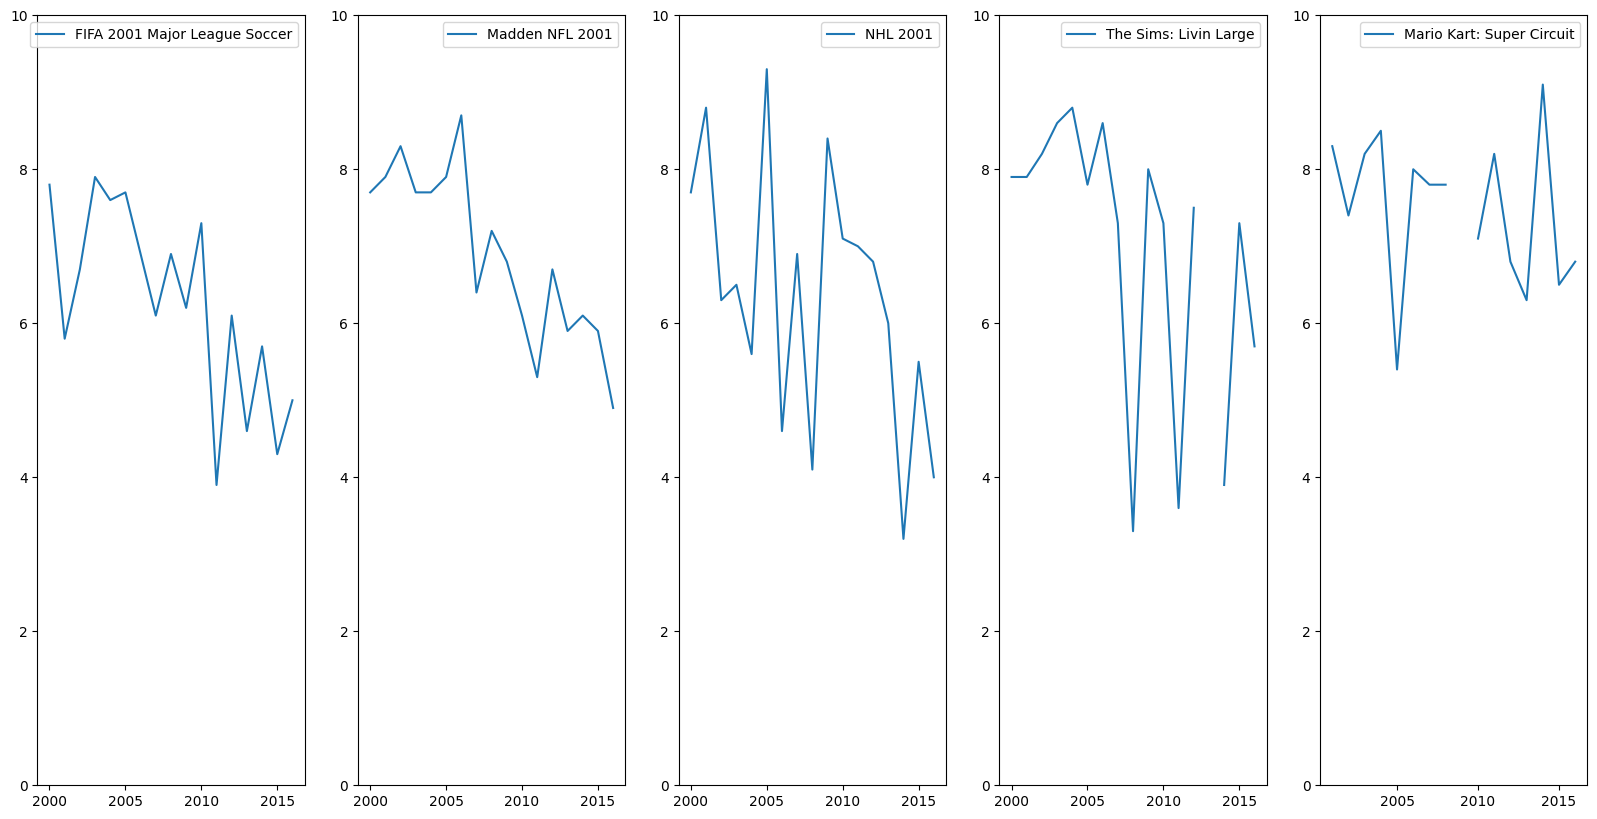

6


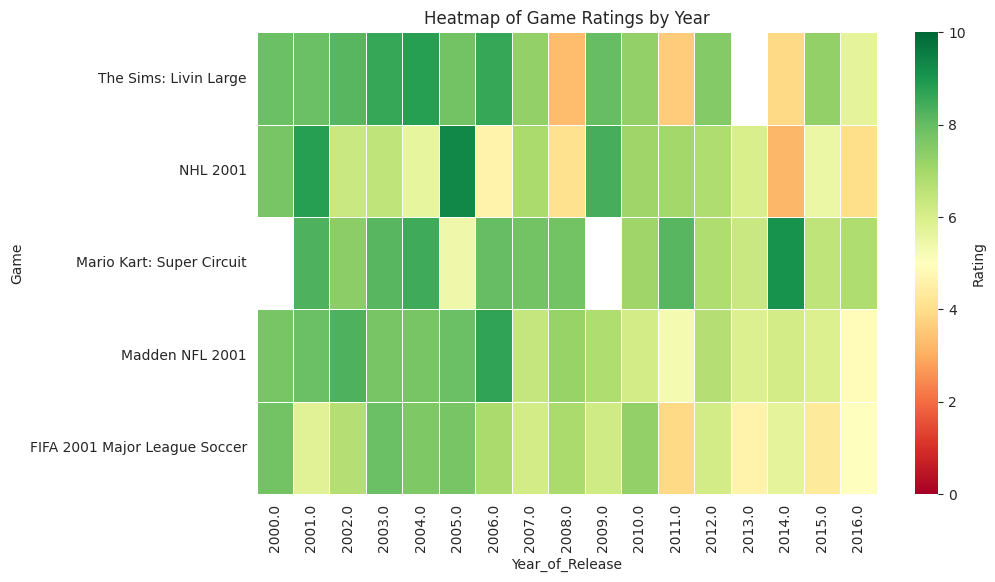

In [28]:
# plot first λ games and their ratings, each game in a subplot
_, axes = plt.subplots(1, σ, figsize=(20, 10))
i = 0
for k, v in df_year_rate4.iloc[:,1:].items():

    axes[i].set_ylim([0, 10])
    axes[i%σ].plot(df_year_rate4.iloc[:,0], v, label=k)
    axes[i%σ].legend()
    i += 1
plt.show()

# plot heatmap of first λ games and their ratings
plot_heatmap_melted(df_year_rate4)


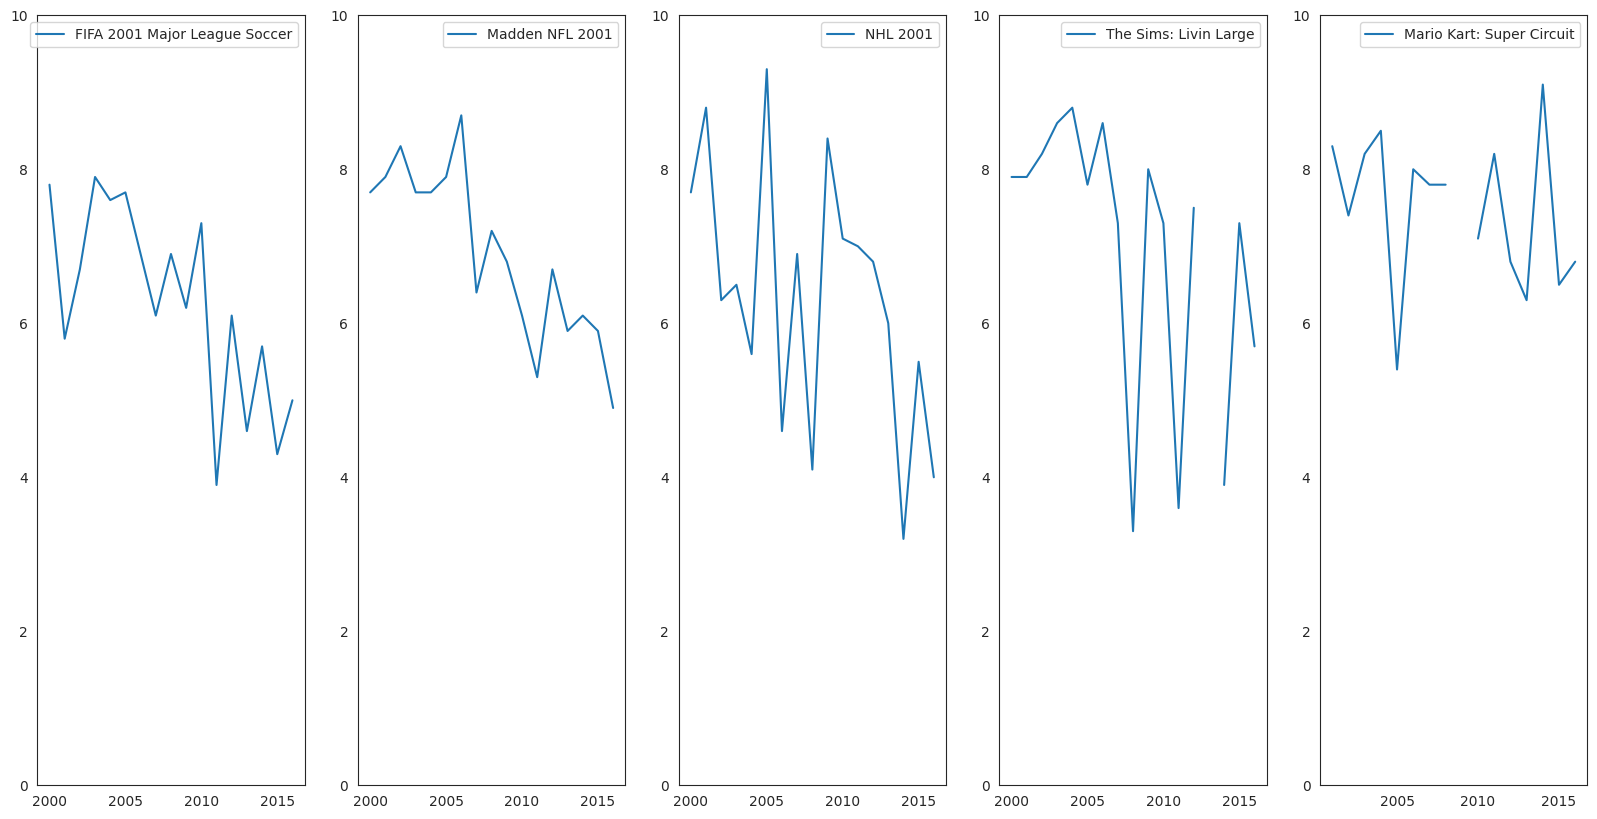

6


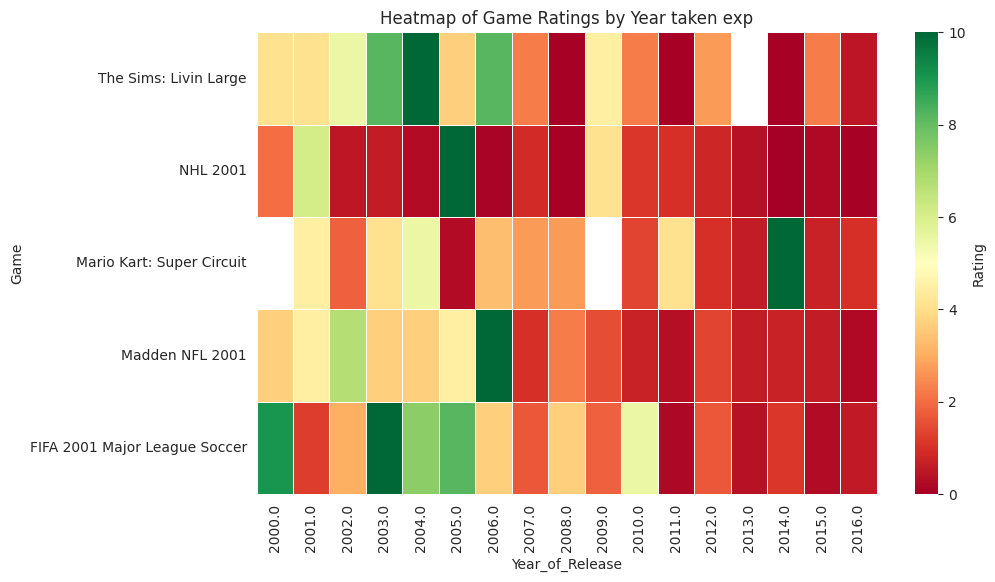

In [29]:
# Plotting with taking exp, normalizing, and multiplying by 10 (to make colors more clear)
# plot first λ games and their ratings, each game in a subplot
_, axes = plt.subplots(1, σ, figsize=(20, 10))
i = 0
for k, v in df_year_rate4.iloc[:,1:].items():

    axes[i].set_ylim([0, 10])
    axes[i%σ].plot(df_year_rate4.iloc[:,0], v, label=k)
    axes[i%σ].legend()
    i += 1
plt.show()

# plot heatmap of first λ games and their ratings
plot_heatmap_melted(df_year_rate4, minimum=0, maximum=10, label='Rating', exp=True)

32


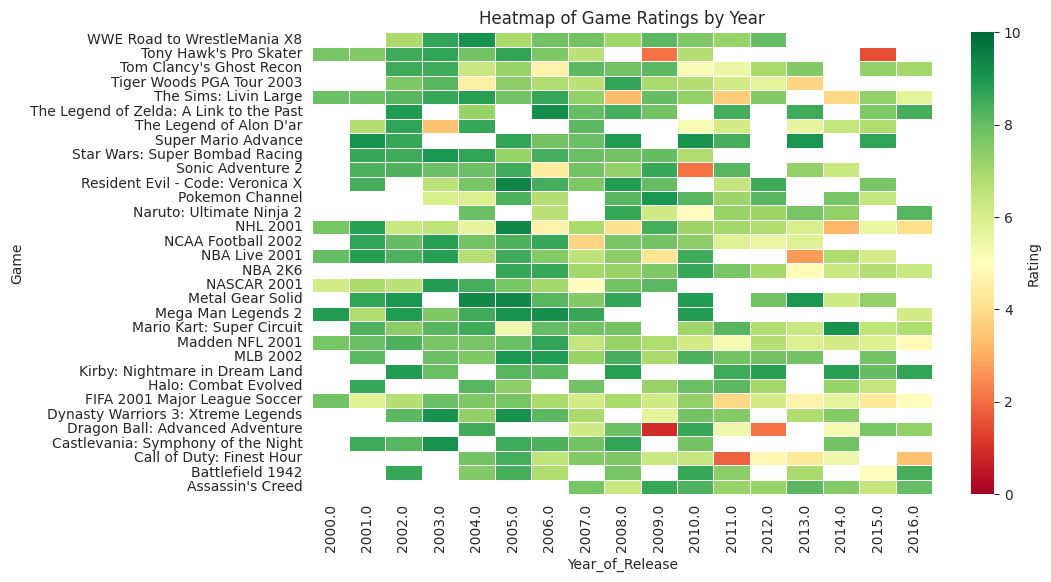

32


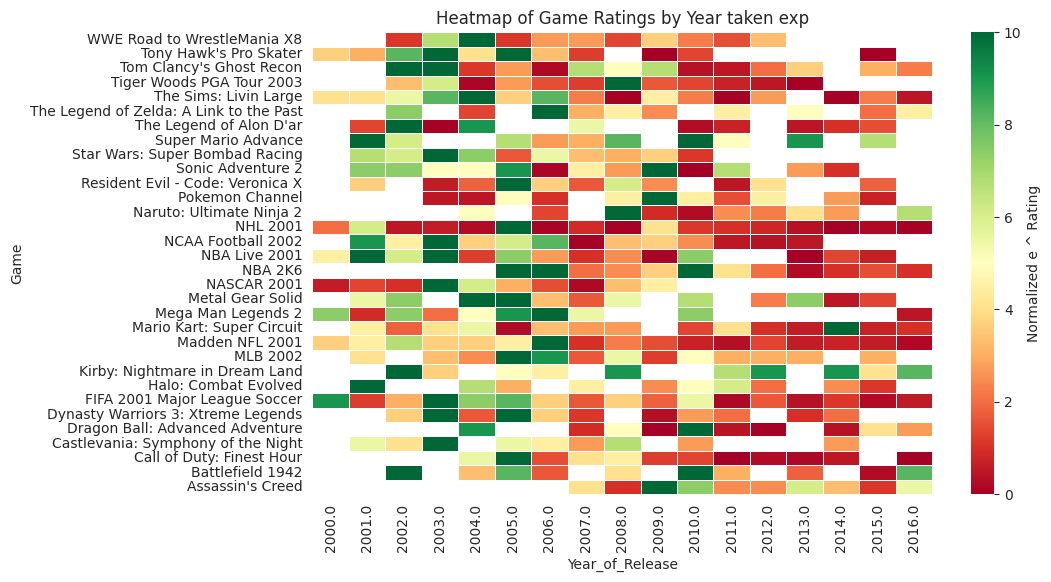

In [30]:
df_year_rate5 = df_year_rate3.copy()
# take years from 2000 to 2016
df_year_rate5 = df_year_rate5.loc[df_year_rate5['Year_of_Release'] >= 2000]
plot_heatmap_melted(df_year_rate5, minimum=0, maximum=10, label='Rating', exp=False)
plot_heatmap_melted(df_year_rate5, minimum=0, maximum=10, label='Normalized e ^ Rating', exp=True)

In [31]:
cnt = 0
for k, v in d_users.items():
    if  len(np.unique(v[1])) >= θ:
        cnt += 1
print(cnt)

32


32


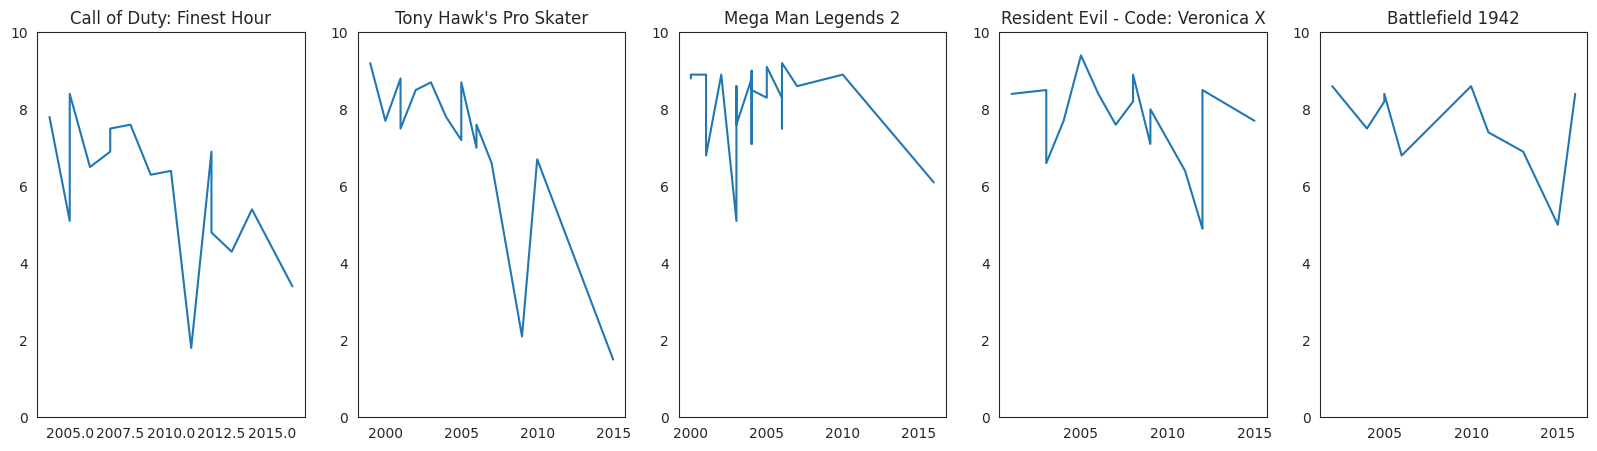

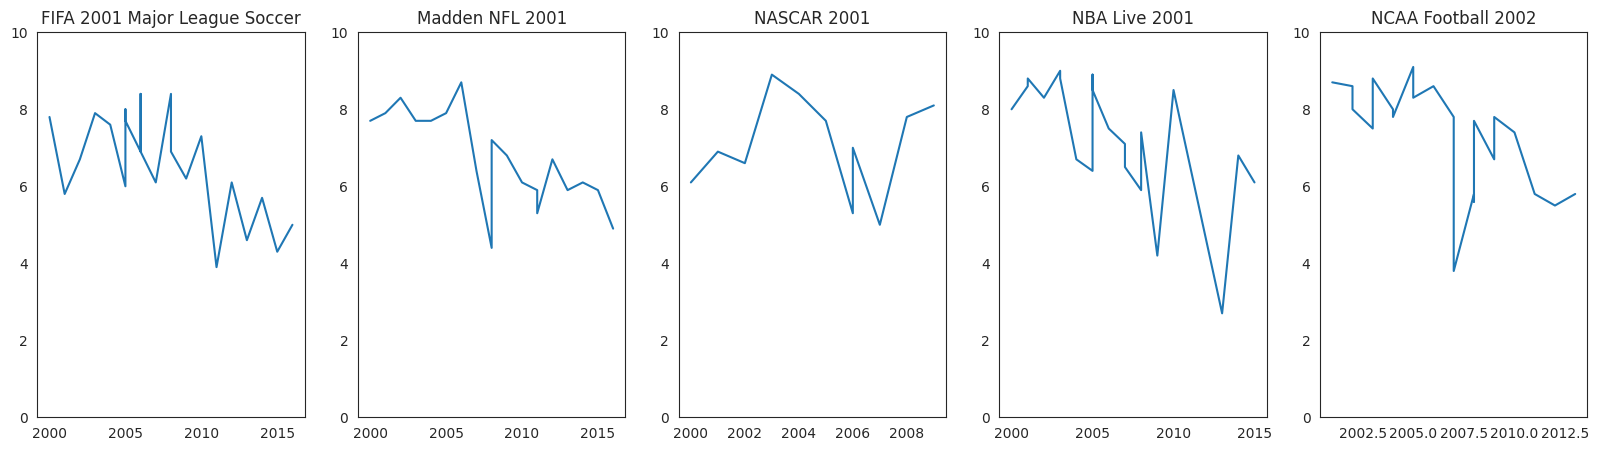

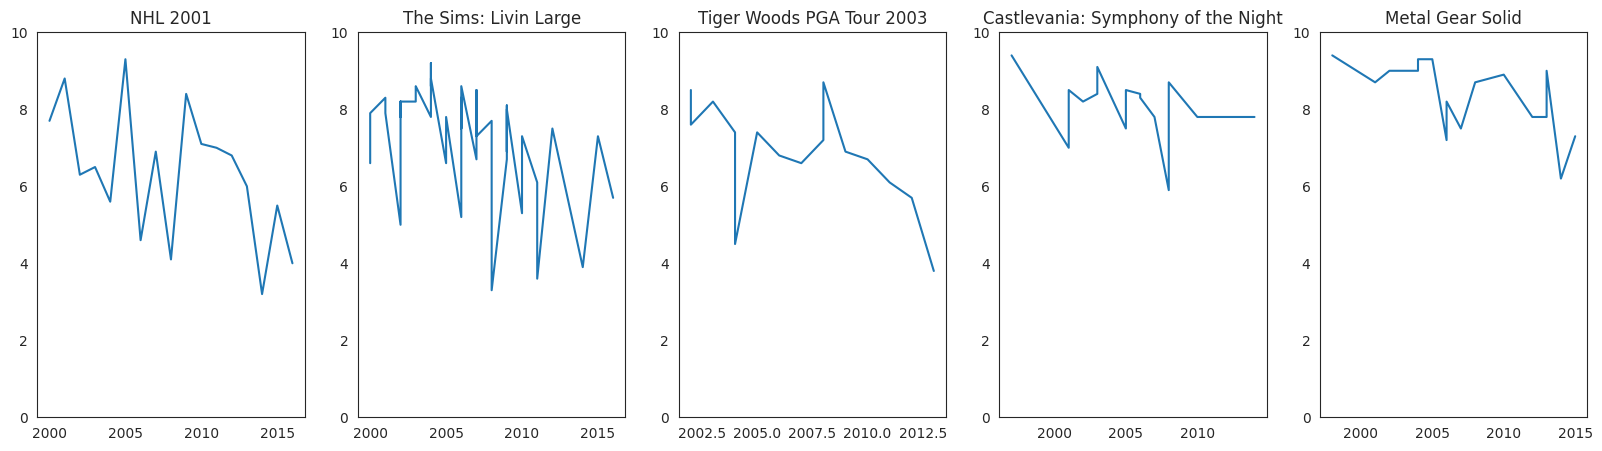

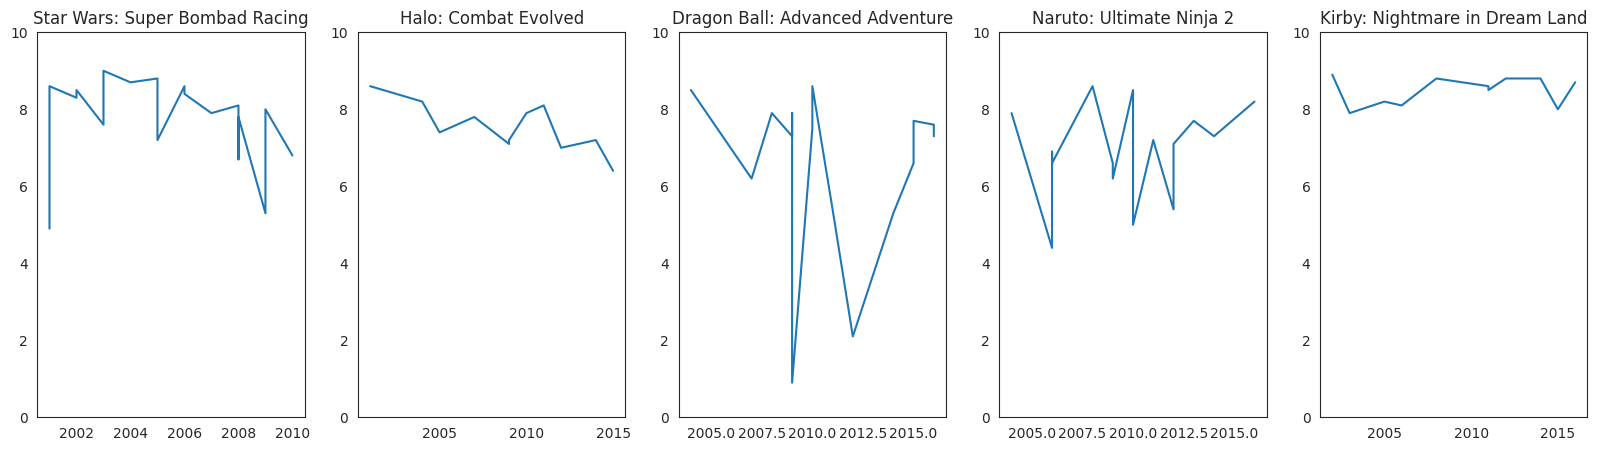

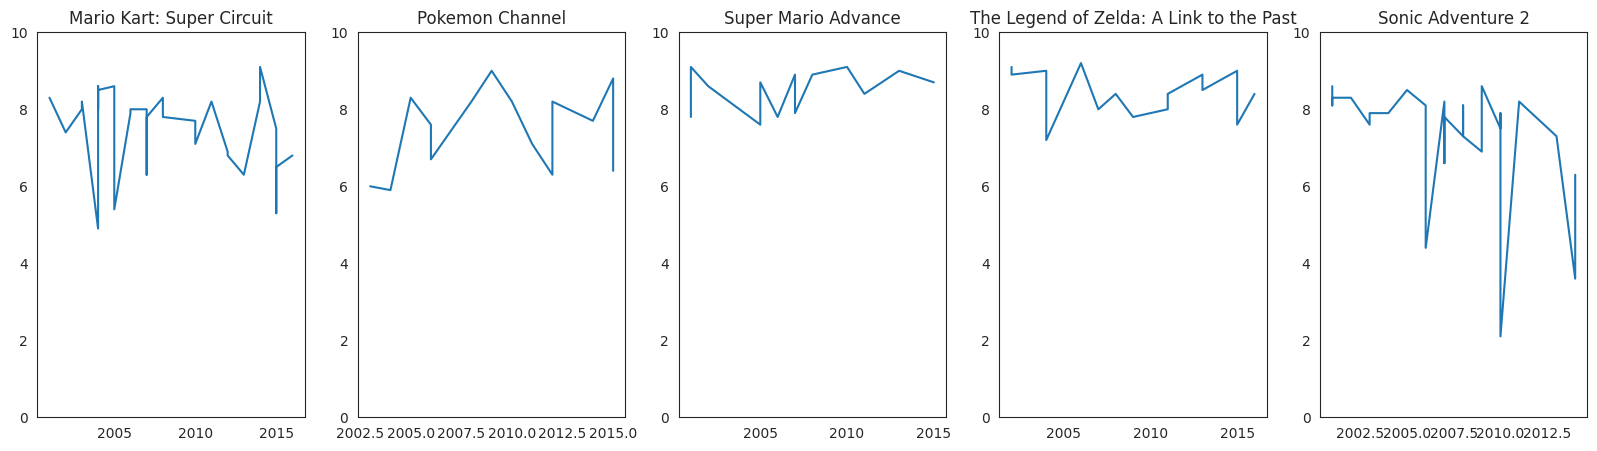

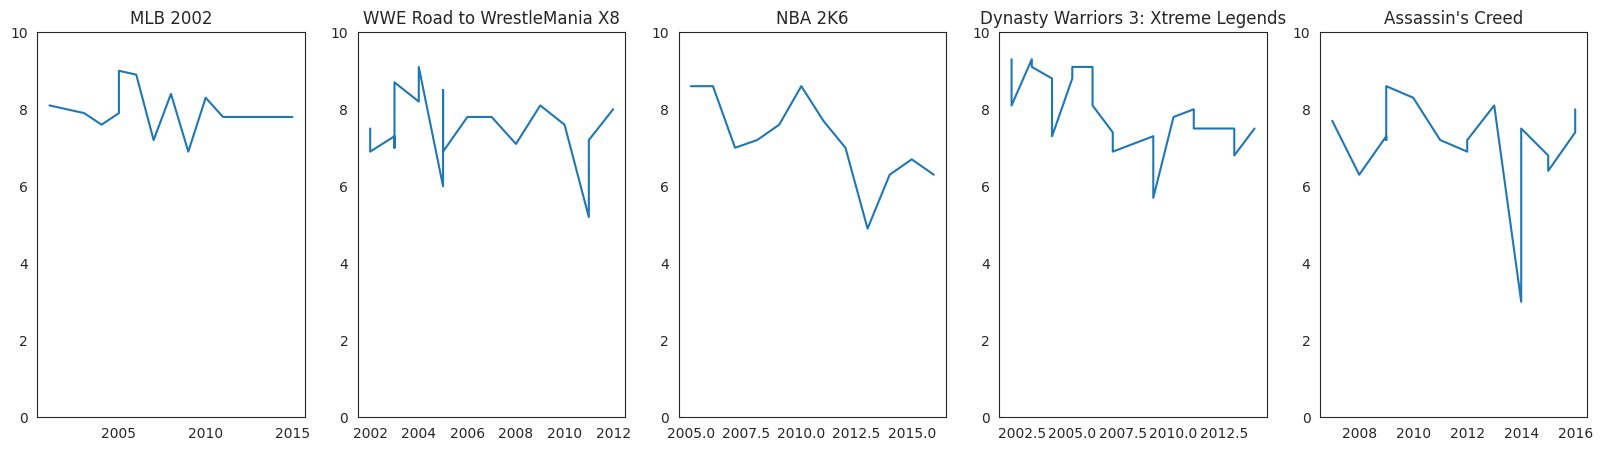

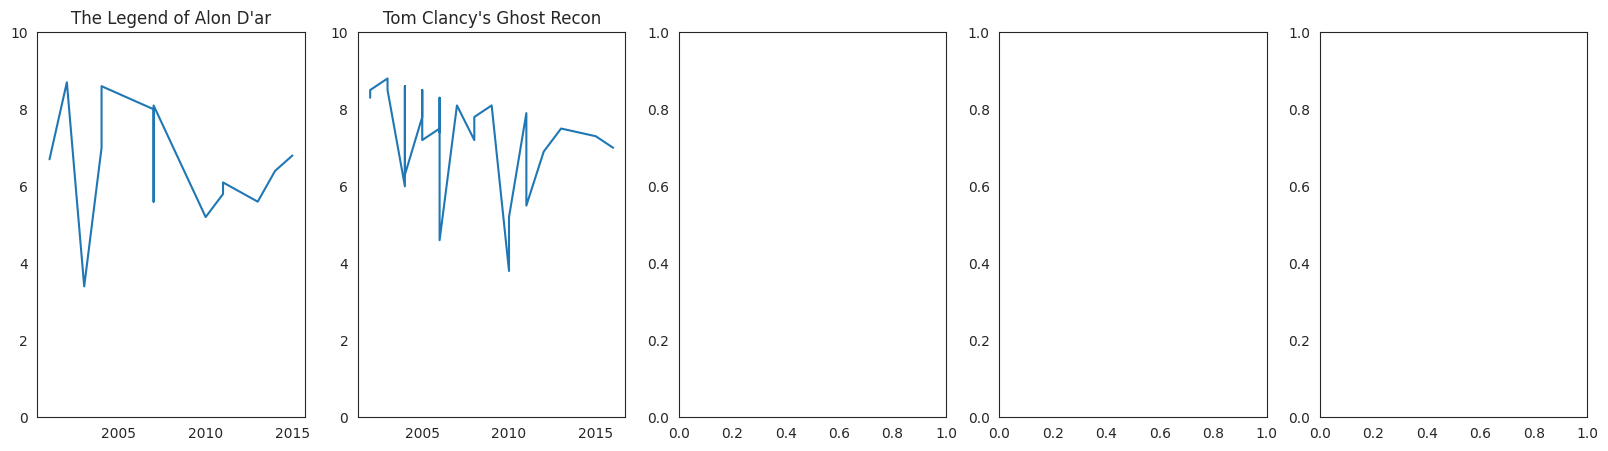

In [32]:
# count of games having more than θ versions
count = 0
for k, v in d_users.items():
    if len(np.unique(v[1])) >= θ:
        count += 1
print(count)

# plot years vs ratings for all games having more than θ versions, each 5 games in a figure
i = 0
_, ax = plt.subplots(1, σ , figsize=(20, 5))
for k, v in d_users.items():
    if len(np.unique(v[1])) >= θ:
        # make y axis in range [0, 10]
        ax[i].set_ylim([0, 10])
        ax[i].plot(v[1], v[0])
        
        ax[i].set_title(k)
        i += 1
        if i % σ == 0:
            plt.show()
            _, ax = plt.subplots(1, σ , figsize=(20, 5))
            i = 0


32


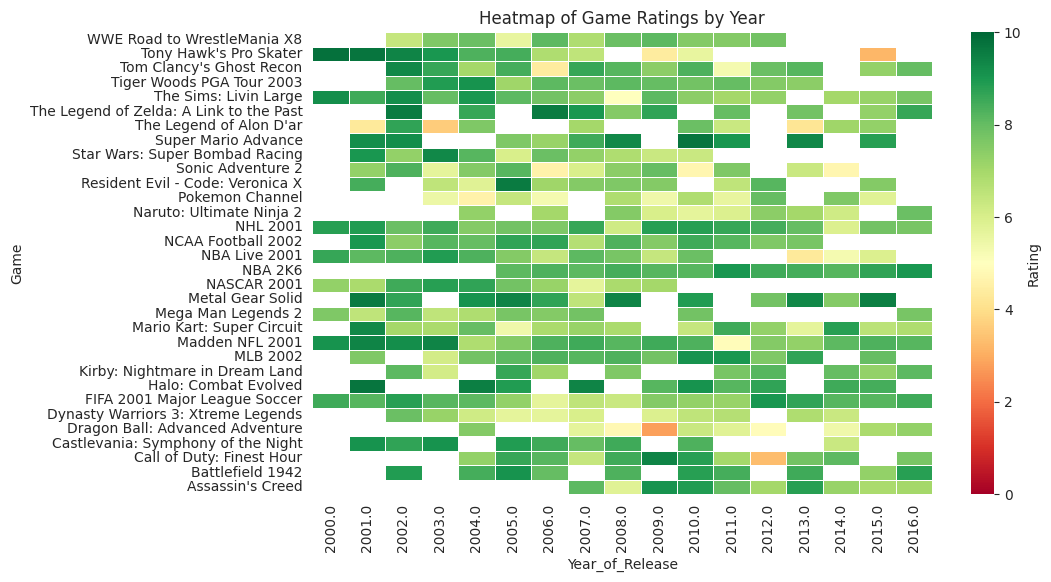

32


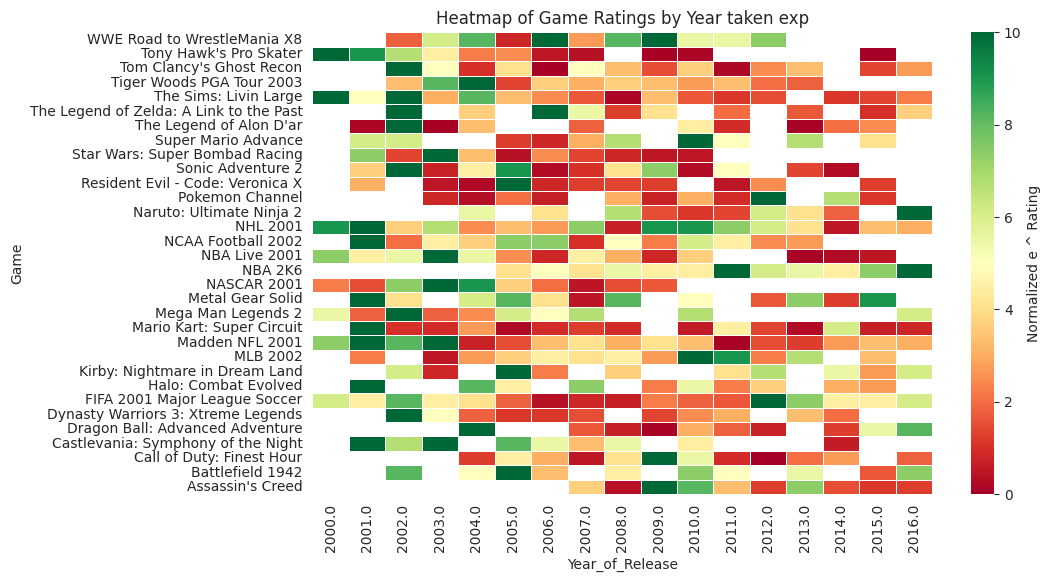

In [33]:
# heatmap for critics
# divide by critics score by 10 to make it in range [0, 10]
df_year_rate_critics4 = df_year_rate_critics3.copy()
# take years from 2000 to 2016
df_year_rate_critics4 = df_year_rate_critics4.loc[df_year_rate_critics4['Year_of_Release'] >= 2000]

plot_heatmap_melted(df_year_rate_critics4, minimum=0, maximum=10, label='Rating', exp=False)
plot_heatmap_melted(df_year_rate_critics4, minimum=0, maximum=10, label='Normalized e ^ Rating', exp=True)

44


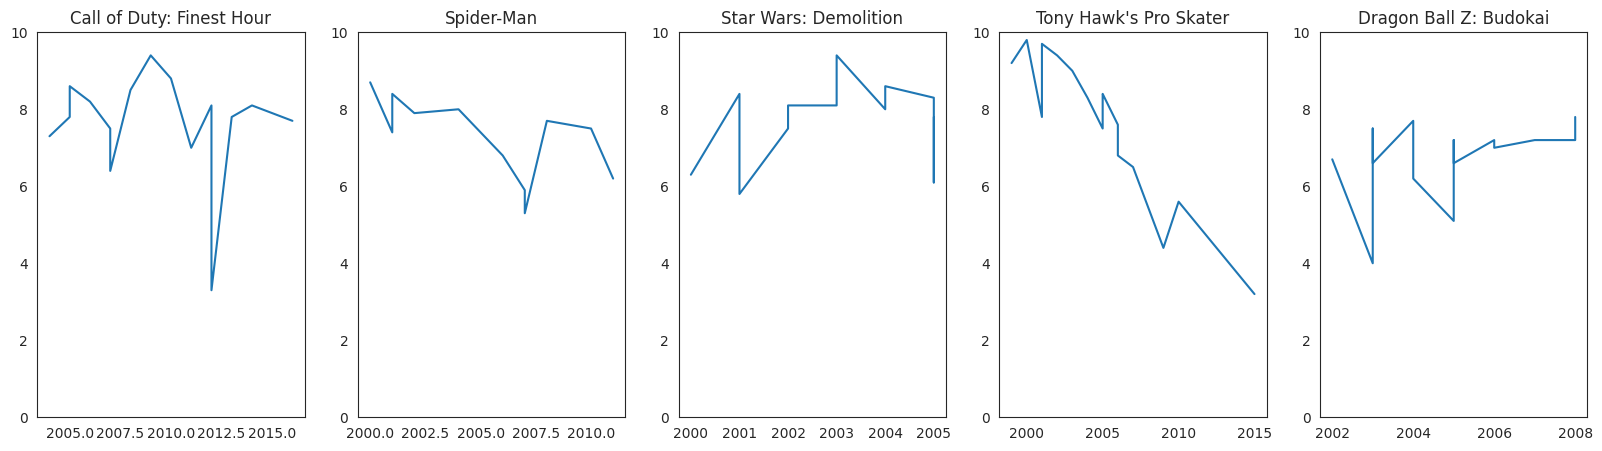

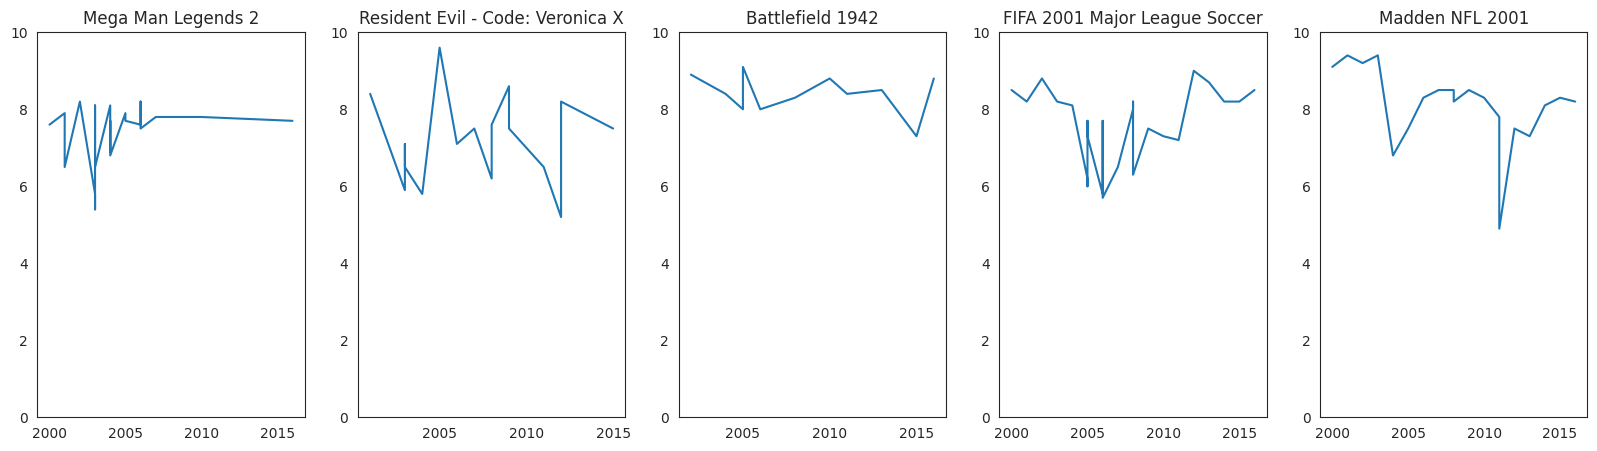

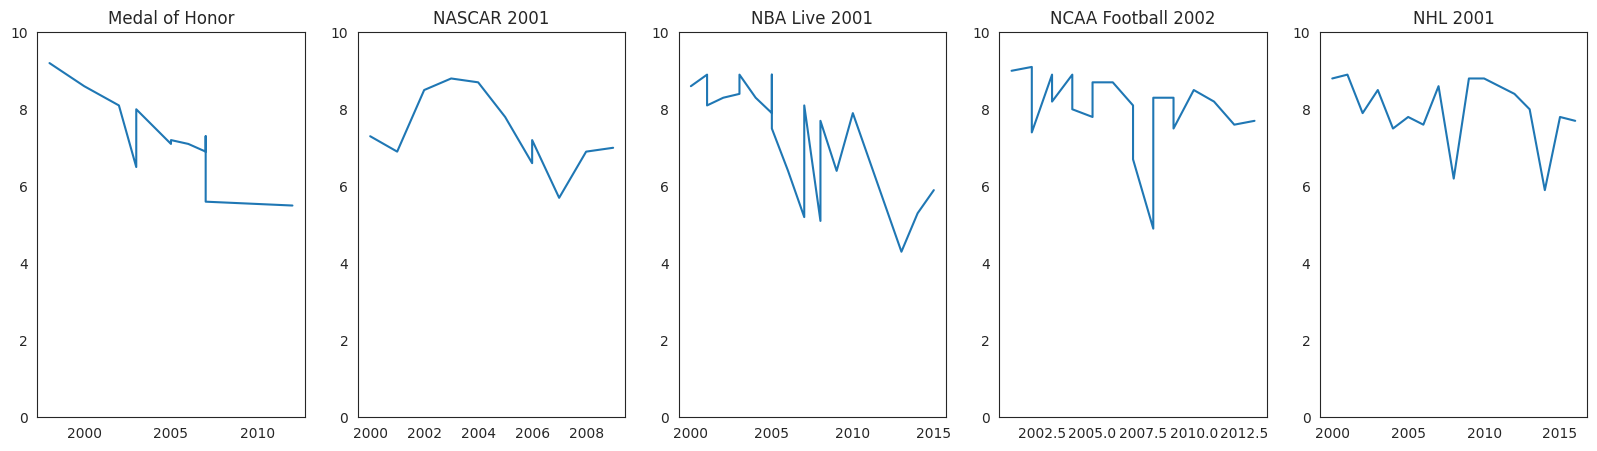

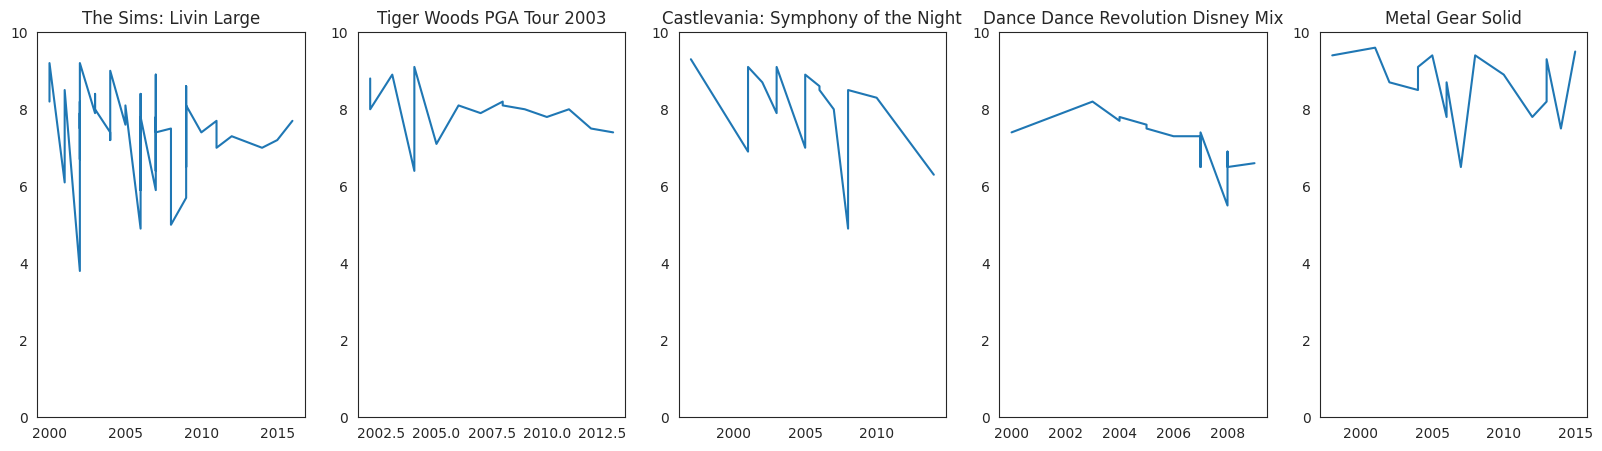

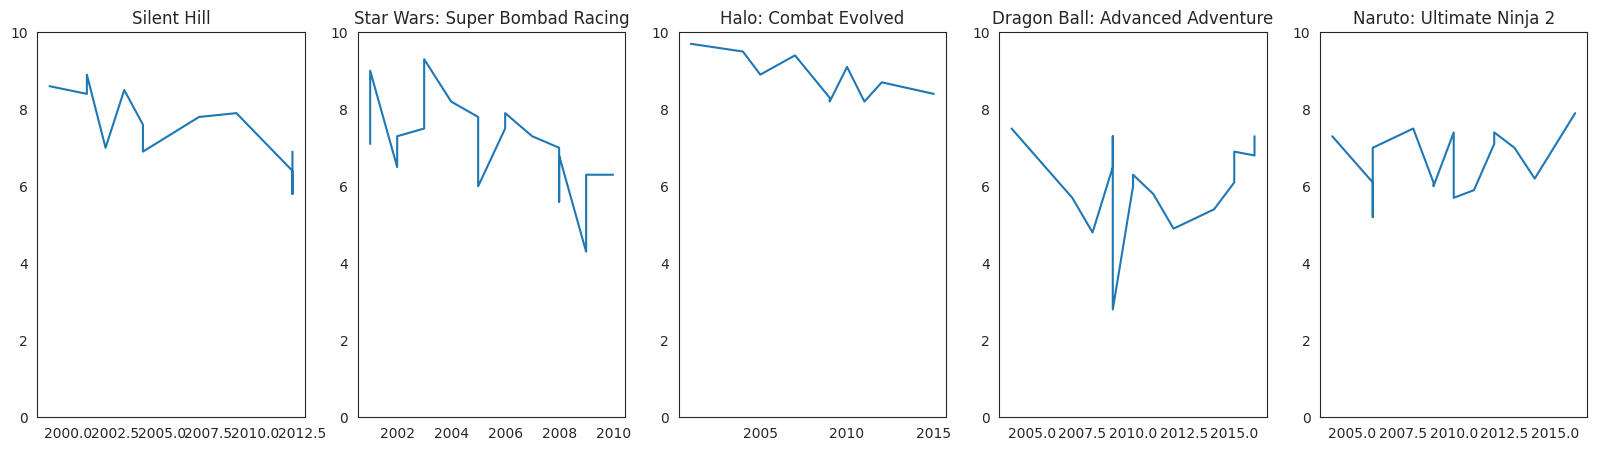

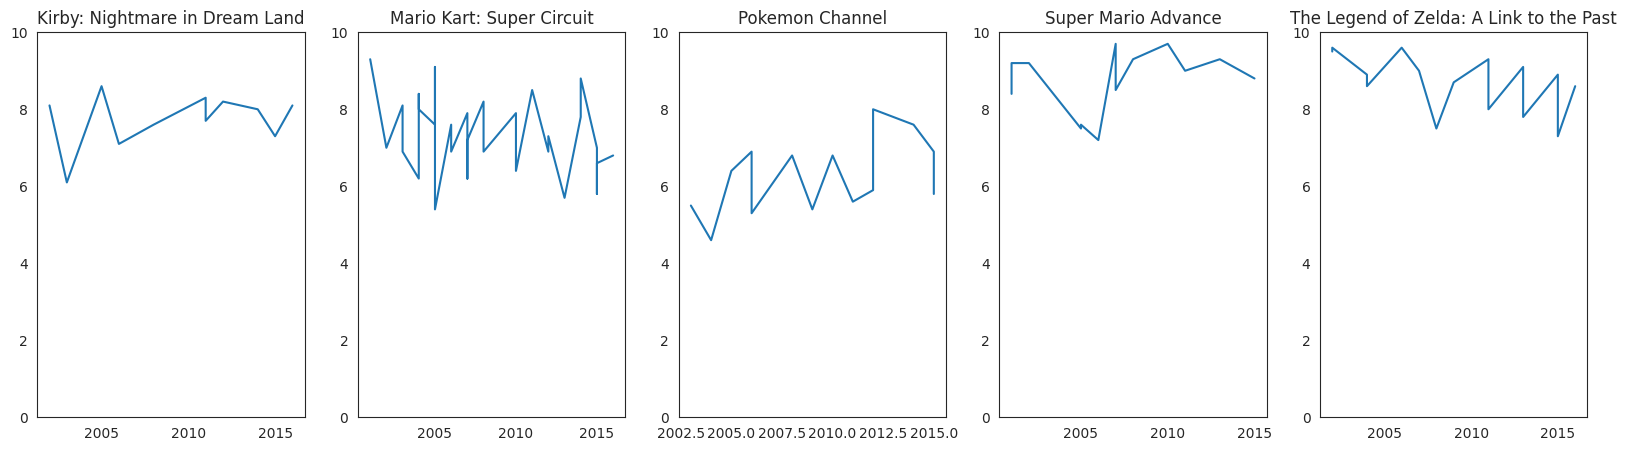

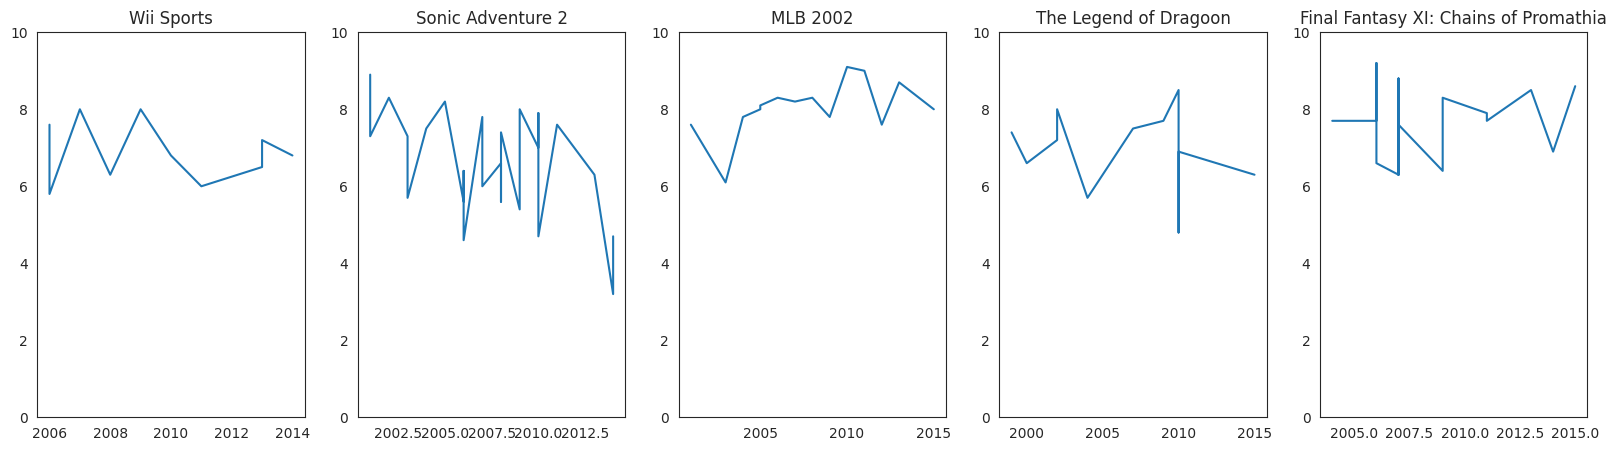

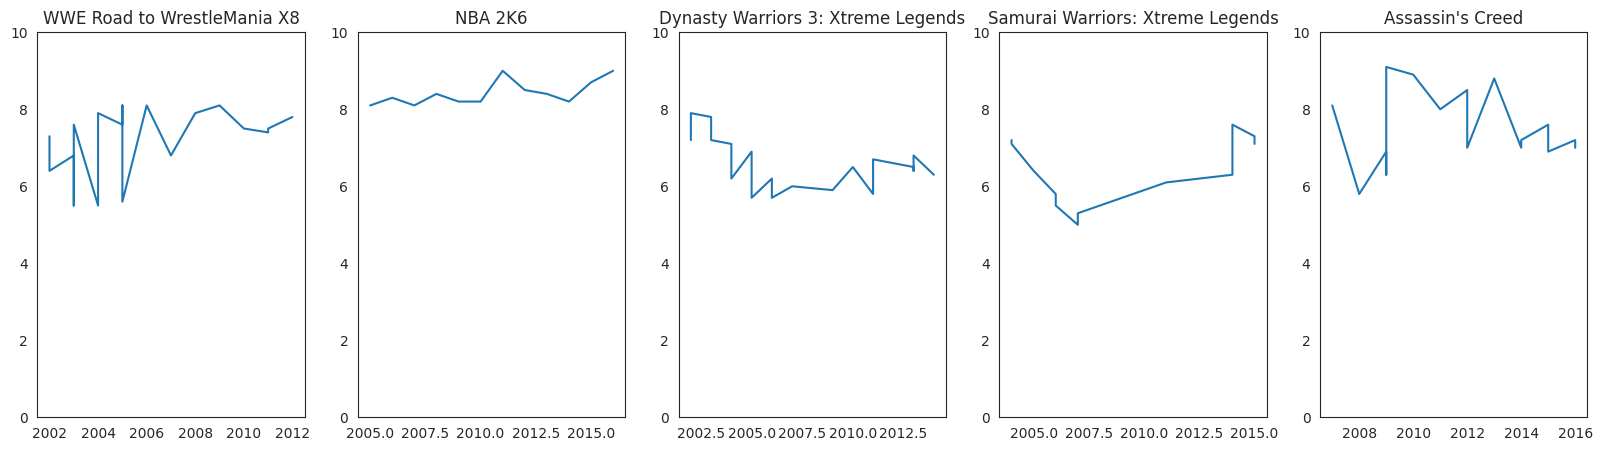

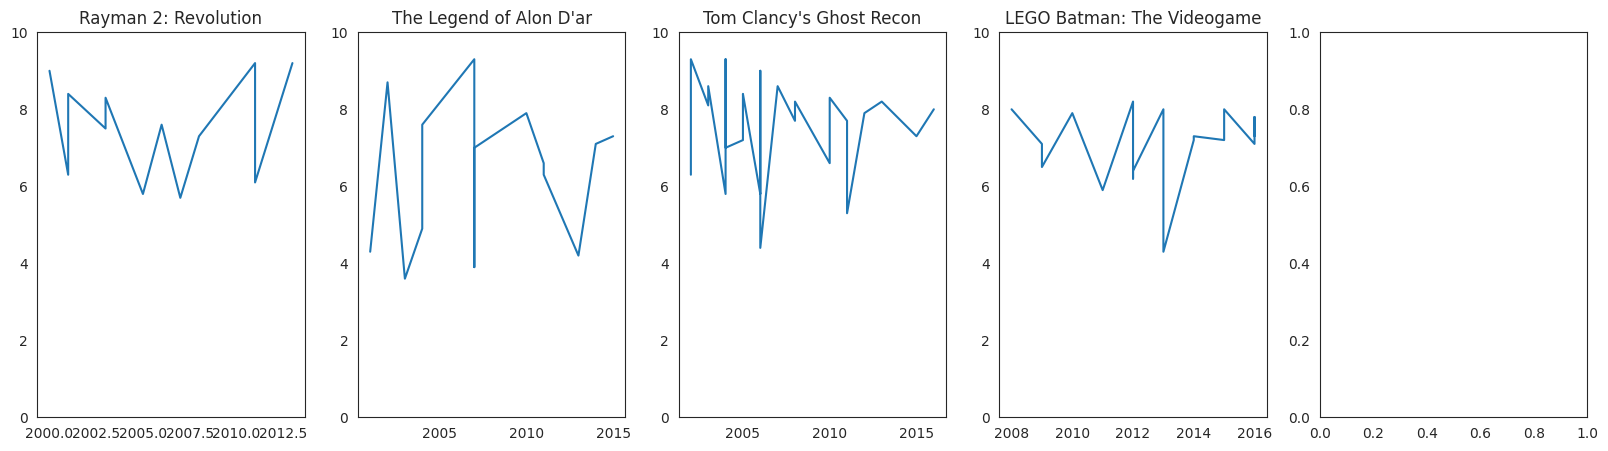

In [34]:
# critics scores
count = 0
for k, v in d_critics.items():
    if len(v[0]) > θ:
        count += 1
print(count)


# plot years vs ratings for all games having more than 10 versions, each 5 games in a figure
i = 0
_, ax = plt.subplots(1, σ , figsize=(20, 5))
for k, v in d_critics.items():
    if len(v[0]) > θ:
        # make y axis in range [0, 100]
        ax[i].set_ylim([0, 10])
        ax[i].plot(v[1], v[0])
        ax[i].set_title(k)
        i += 1
        if i % σ == 0:
            plt.show()
            _, ax = plt.subplots(1, σ , figsize=(20, 5))
            i = 0
            

44


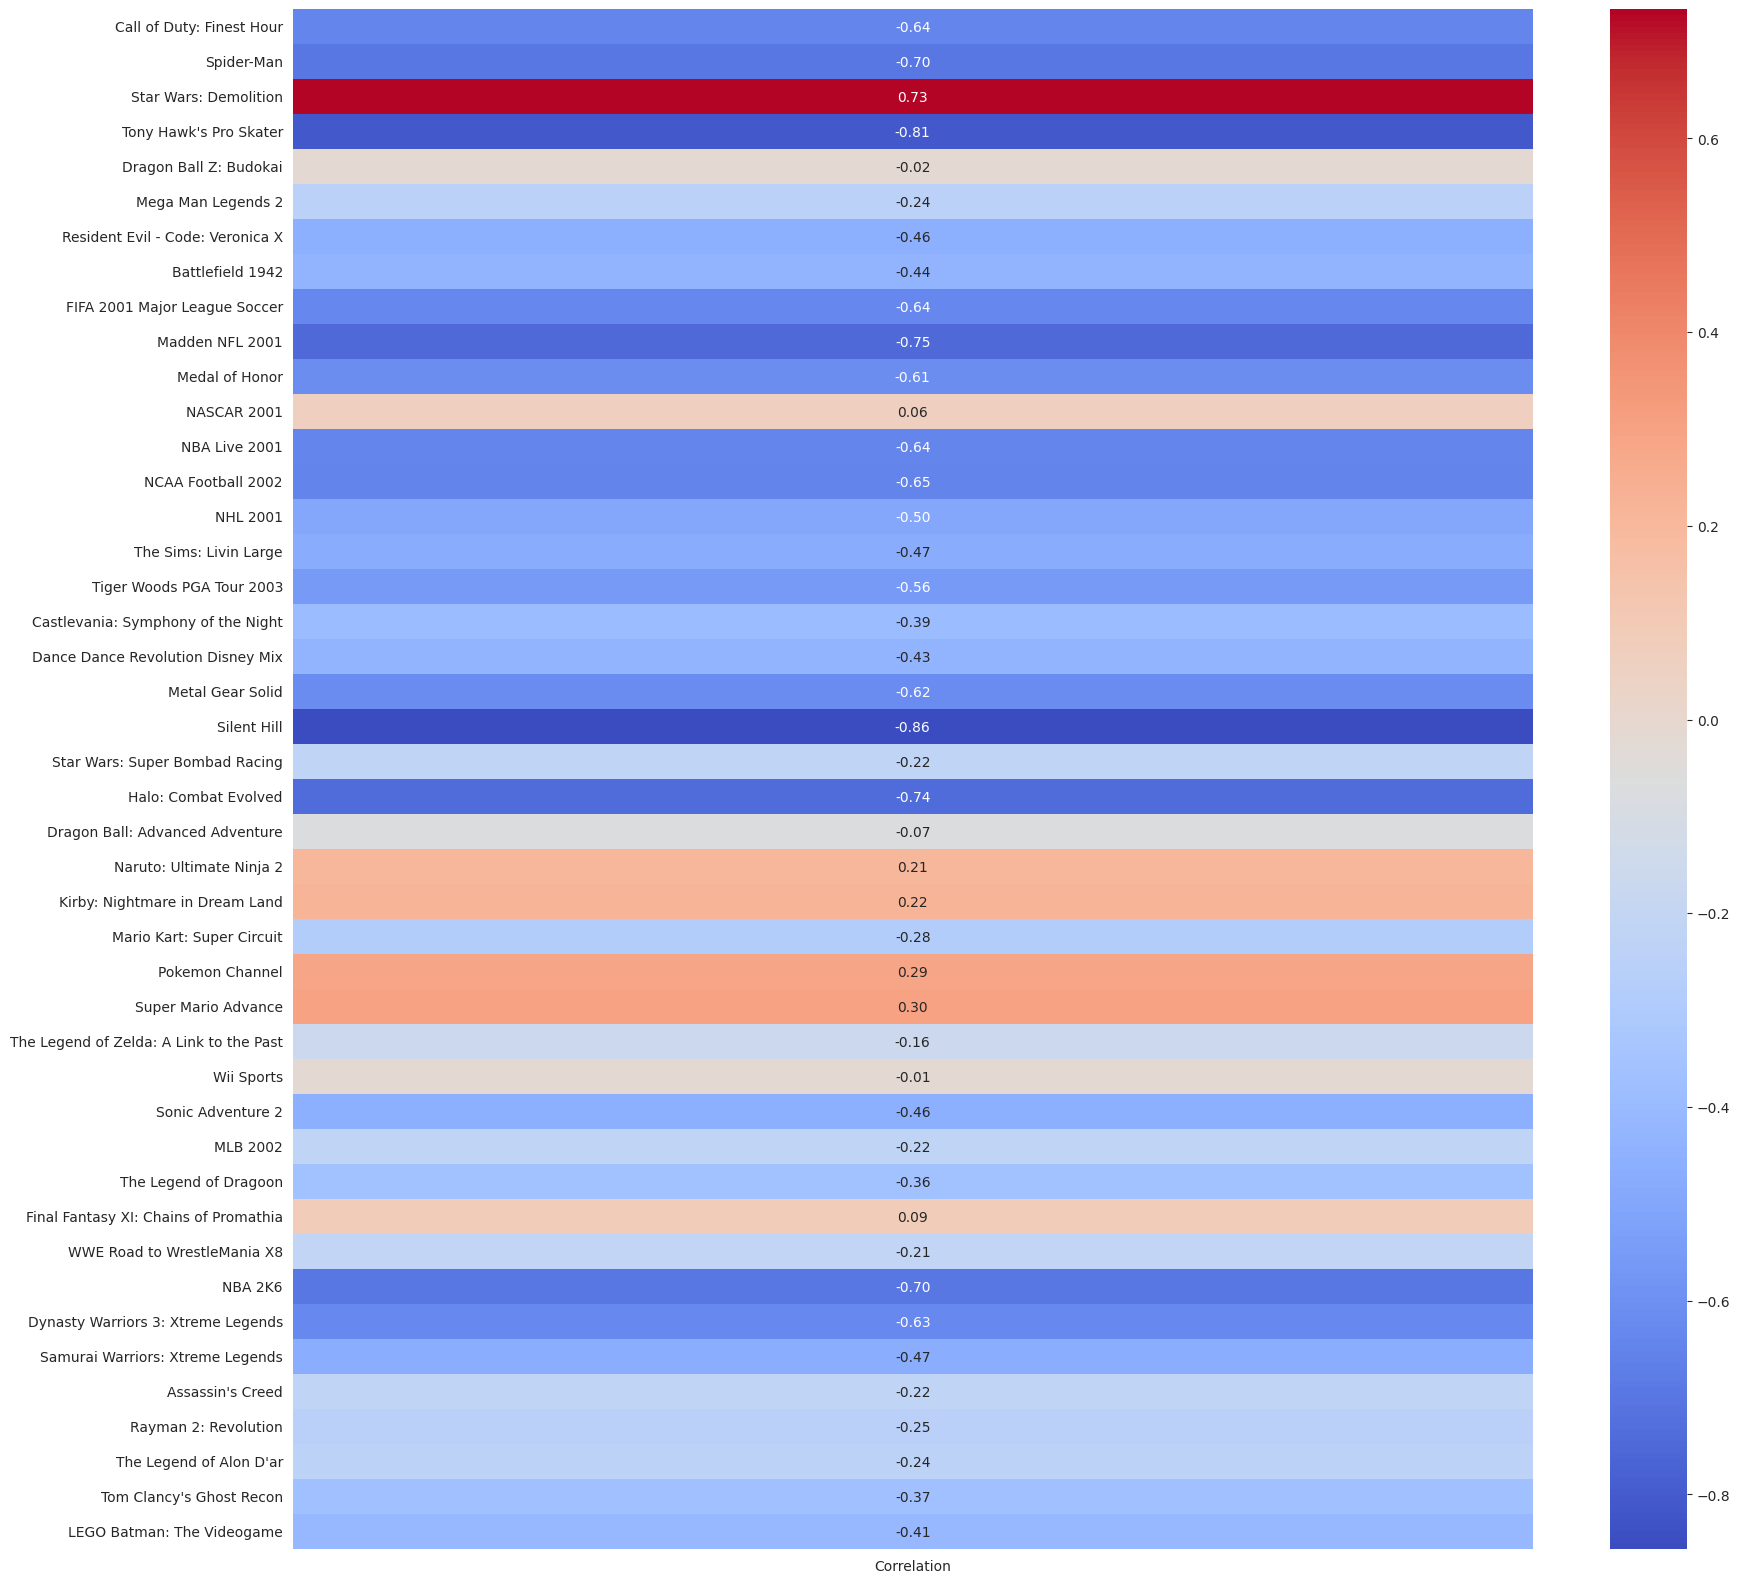

In [35]:
# analytically show if there is a correlation between the year of release and user score (or critic score)
# for each game, compute the correlation between year of release and user score
# first convert the dictionary to a dataframe, filter out games having less than θ versions
# then compute the correlation between year of release and user score
df_users = pd.DataFrame.from_dict(d_users, orient='index', columns=['User_Score', 'Year_of_Release'])
df_users = df_users[df_users['User_Score'].map(len) > θ]
print(len(df_users))
df_users['Correlation'] = df_users.apply(lambda x: np.corrcoef(x['User_Score'], x['Year_of_Release'])[0, 1], axis=1)

# heatmap of correlation between year of release and user score for all games
plt.figure(figsize=(20, 20))
sns.heatmap(df_users['Correlation'].to_frame(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()


In [36]:
# average correlation between year of release and user score for positive correlation
print(df_users[df_users['Correlation'] > 0]['Correlation'].mean())

# average correlation between year of release and user score for negative correlation
print(df_users[df_users['Correlation'] < 0]['Correlation'].mean())


0.2727526234150287
-0.4445557036639504


# Hypohesis testing
### Null Hypothesis: 
        there is no correlation between year of release and user score for a specific game

### Alternative Hypothesis:
        there is a correlation between year of release and user score for a specific game
        

In [37]:
α = 0.05 # significance level

In [38]:
correlated_games_names = []

In [39]:
# stats
# null hypothesis: there is no correlation between year of release and user score
# alternative hypothesis: there is a correlation between year of release and user score
import scipy.stats as stats
# correlation between year of release and user score for all games
pos_corr_cnt = 0
neg_corr_cnt = 0
print("Games having more than 10 versions, with correlation between year of release and user score")
print("-----------------------------------")
for k, v in d_users.items():
    if len(v[0]) > 2:  
        corr, p = stats.pearsonr(v[0], v[1])
        if p < α and len(np.unique(v[1])) >= θ and np.abs(corr) > 0.5:
                print('Game: ', k, 'Correlation: ', corr, 'p-value: ', p)
                correlated_games_names.append(k)

        if corr > 0:
            pos_corr_cnt += 1
        else:
            neg_corr_cnt += 1

print('-----------------------------------')
print('pos_corr_cnt, neg_corr_cnt')
print(pos_corr_cnt, neg_corr_cnt)
print('percentage of positive correlation')
print(pos_corr_cnt / (pos_corr_cnt + neg_corr_cnt))
print('percentage of negative correlation')
print(neg_corr_cnt / (pos_corr_cnt + neg_corr_cnt))
# percentage of correlated games to all games
print('percentage of correlated games to all games')
print((pos_corr_cnt + neg_corr_cnt) / len(d_users))


Games having more than 10 versions, with correlation between year of release and user score
-----------------------------------
Game:  Call of Duty: Finest Hour Correlation:  -0.6438614061601242 p-value:  0.009589901422744948
Game:  Tony Hawk's Pro Skater Correlation:  -0.8120269210508245 p-value:  0.00013311704998666995
Game:  FIFA 2001 Major League Soccer Correlation:  -0.6384600330354756 p-value:  0.0007866927355099688
Game:  Madden NFL 2001 Correlation:  -0.7471664043860189 p-value:  0.0002367037399700044
Game:  NBA Live 2001 Correlation:  -0.6410878751098653 p-value:  0.0023186489661288934
Game:  NCAA Football 2002 Correlation:  -0.6478908489488029 p-value:  0.0011126991256521976
Game:  Tiger Woods PGA Tour 2003 Correlation:  -0.5579976340761164 p-value:  0.030649895512486158
Game:  Metal Gear Solid Correlation:  -0.6158276719775371 p-value:  0.011089981251596728
Game:  Halo: Combat Evolved Correlation:  -0.7439614309252156 p-value:  0.008659740466781661
Game:  NBA 2K6 Correlation

/home/akram/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


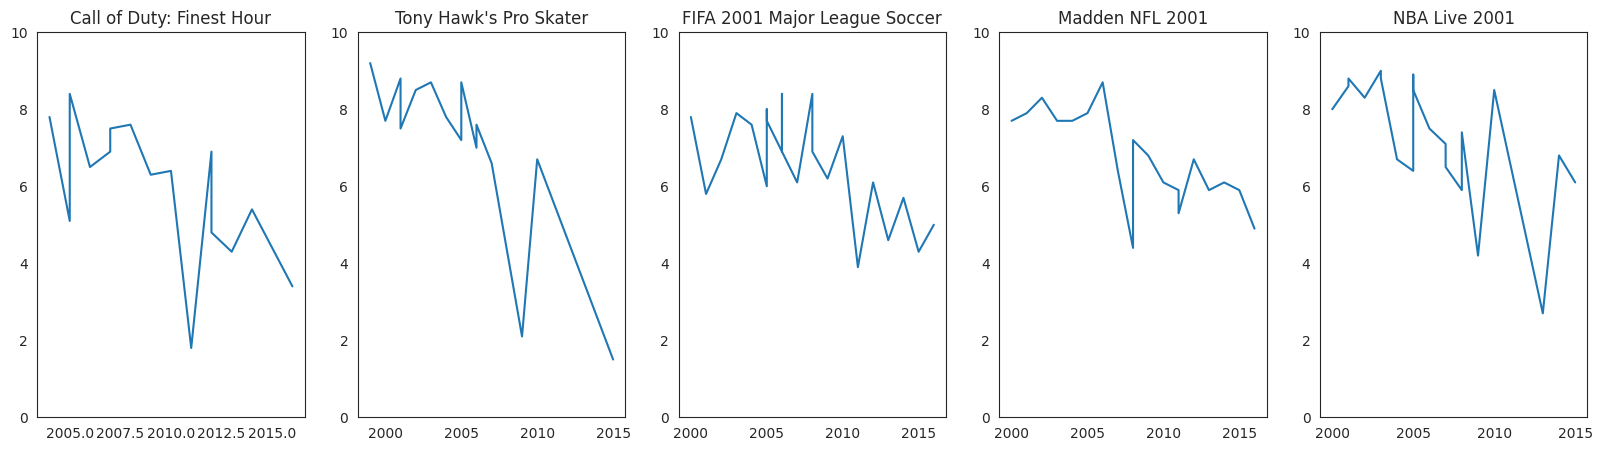

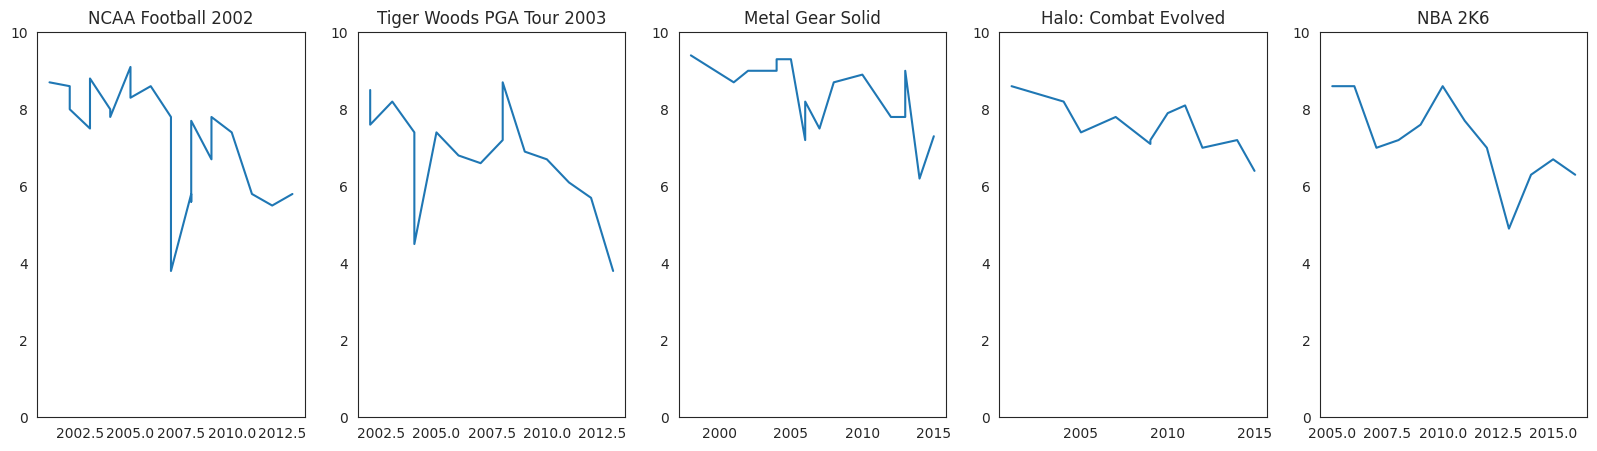

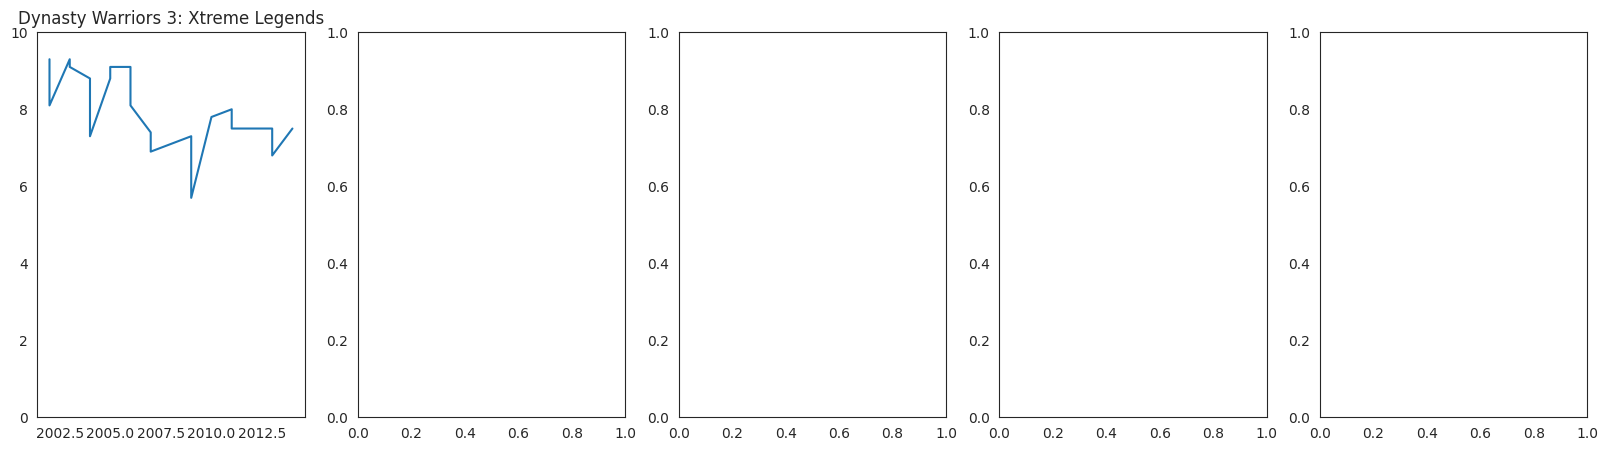

In [40]:
# plot correlated games and their ratings
i = 0
_, ax = plt.subplots(1, σ , figsize=(20, 5))
for k, v in d_users.items():
    if k in correlated_games_names:
        # make y axis in range [0, 10]
        ax[i].set_ylim([0, 10])
        ax[i].plot(v[1], v[0])
        ax[i].set_title(k)
        i += 1
        if i % σ == 0:
            plt.show()
            _, ax = plt.subplots(1, σ , figsize=(20, 5))
            i = 0
            

12


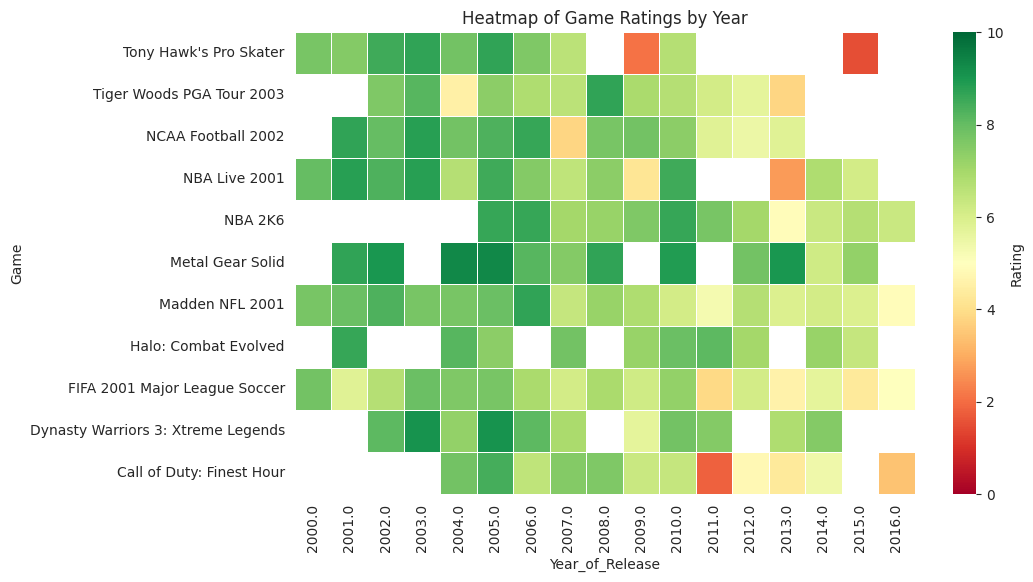

12


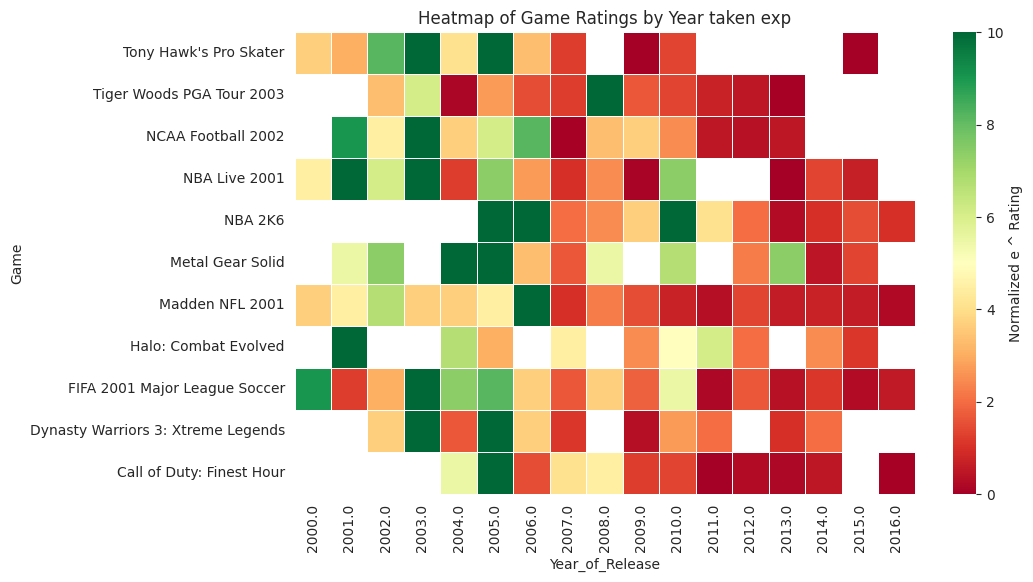

In [41]:
# plot correlated games and their ratings (heatmap)
df_year_rate6 = df_year_rate2.copy()
# take years from 2000 to 2016
df_year_rate6 = df_year_rate6.loc[df_year_rate6['Year_of_Release'] >= 2000]
df_year_rate6 = df_year_rate6[['Year_of_Release', *correlated_games_names]]

plot_heatmap_melted(df_year_rate6, minimum=0, maximum=10, label='Rating', exp=False)
plot_heatmap_melted(df_year_rate6, minimum=0, maximum=10, label='Normalized e ^ Rating', exp=True)

44


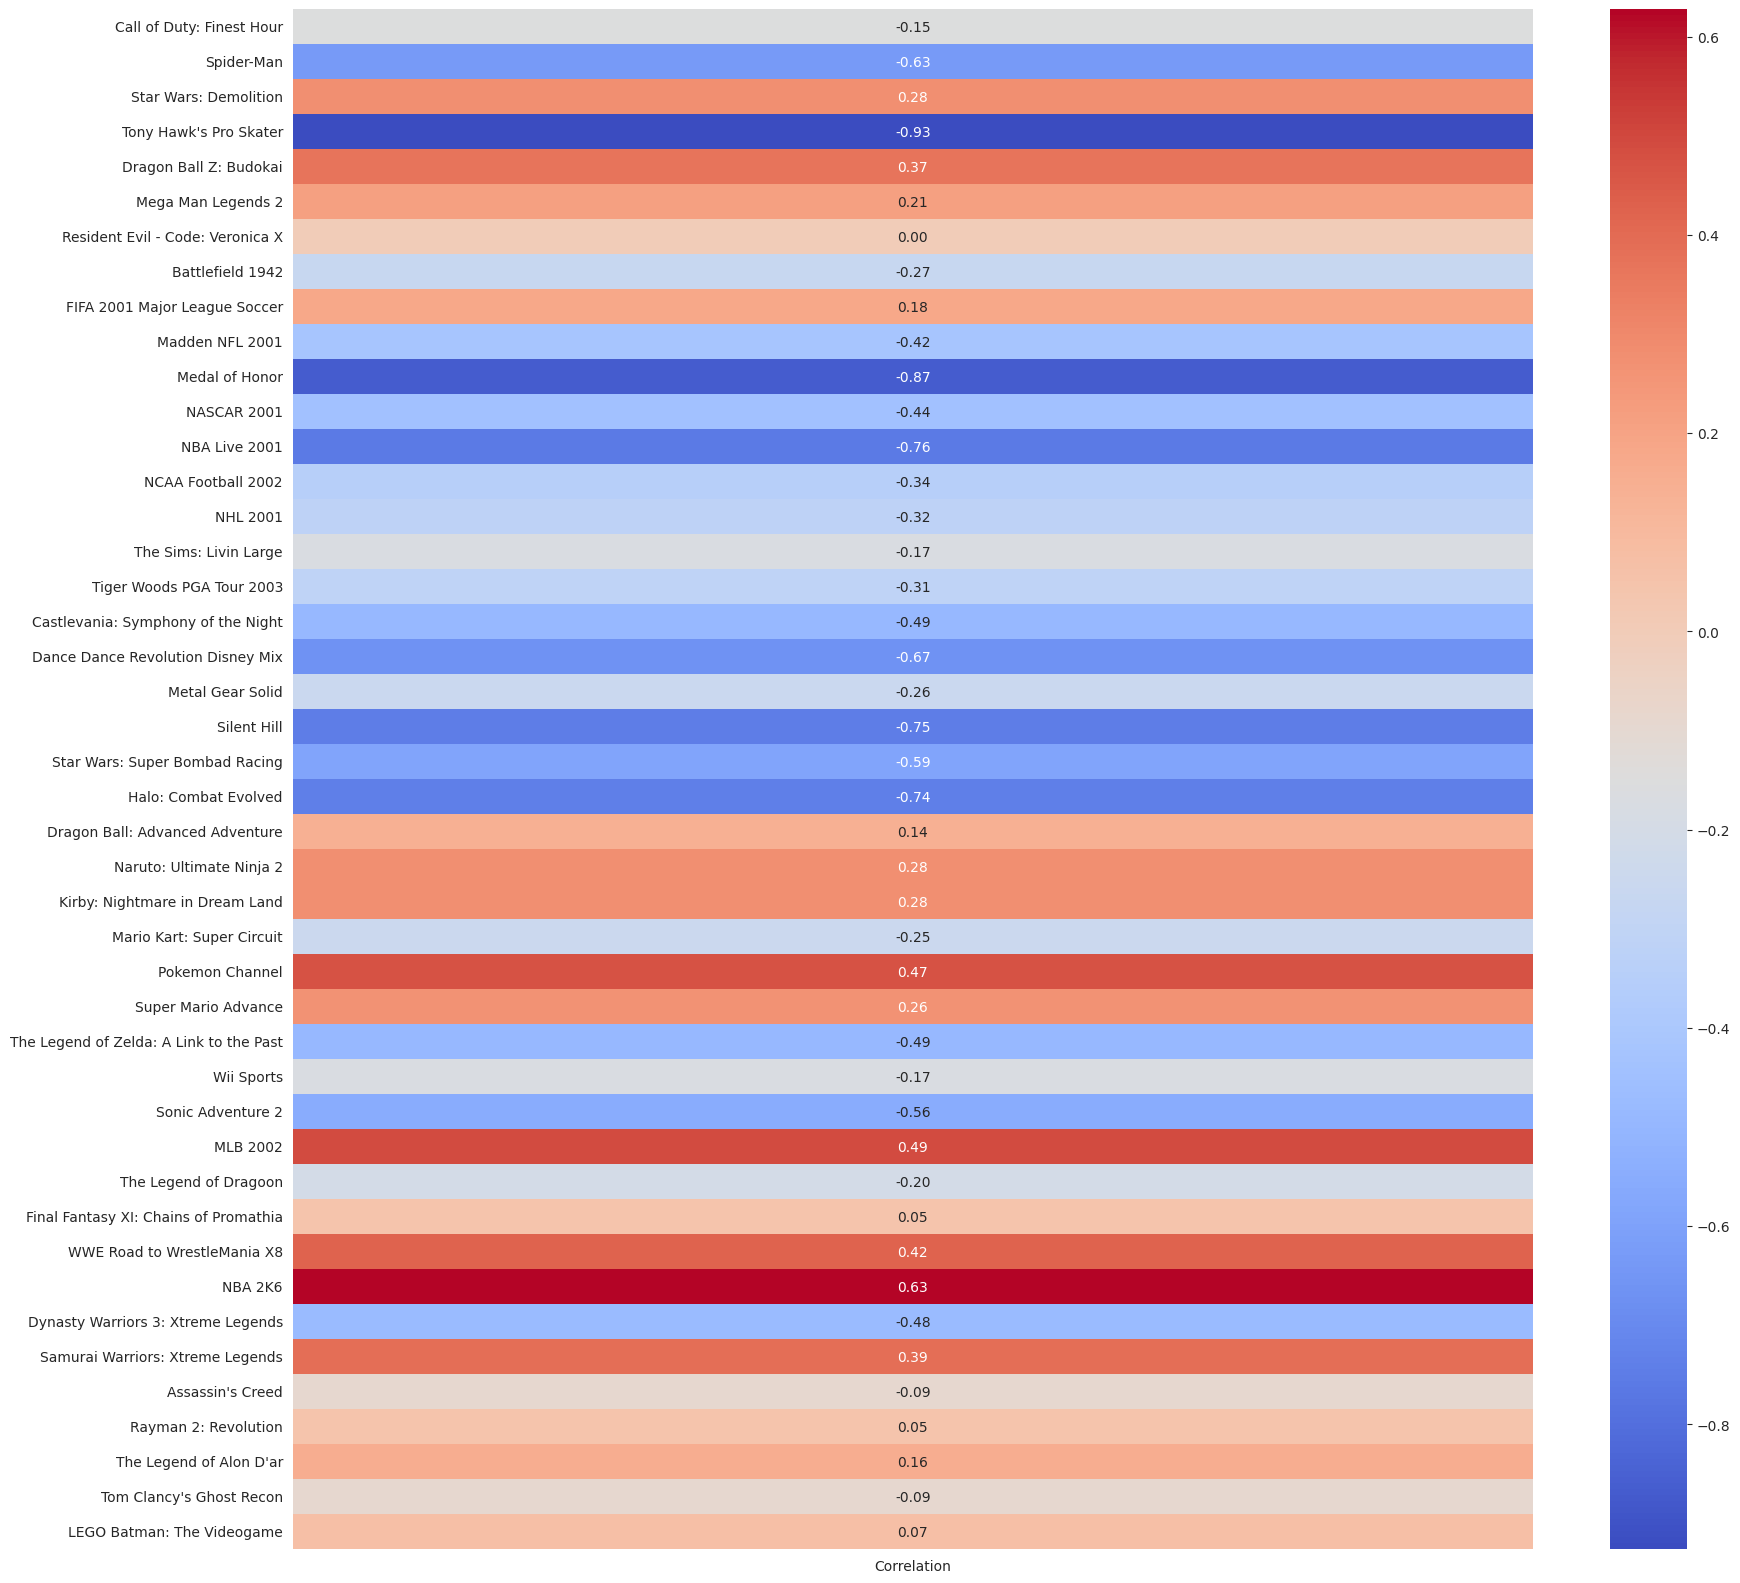

0.26316246662438186
-0.44012983439490905


In [42]:
# critic scores vs year of release
df_critics = pd.DataFrame.from_dict(d_critics, orient='index', columns=['Critic_Score', 'Year_of_Release'])
df_critics = df_critics[df_critics['Critic_Score'].map(len) > θ]
print(len(df_critics))
df_critics['Correlation'] = df_critics.apply(lambda x: np.corrcoef(x['Critic_Score'], x['Year_of_Release'])[0, 1], axis=1)

# heatmap of correlation between year of release and critic score for all games
plt.figure(figsize=(20, 20))
sns.heatmap(df_critics['Correlation'].to_frame(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

# average correlation between year of release and critic score for positive correlation
print(df_critics[df_critics['Correlation'] > 0]['Correlation'].mean())

# average correlation between year of release and critic score for negative correlation
print(df_critics[df_critics['Correlation'] < 0]['Correlation'].mean())


In [43]:
correlated_games_names = []

In [44]:
# stats
import scipy.stats as stats
# correlation between year of release and critic score for all games
pos_corr_cnt = 0
neg_corr_cnt = 0

print("Games having more than 10 versions, with correlation between year of release and critic score")
print("-----------------------------------")

for k, v in d_critics.items():
    if len(v[0]) > 2:  
        corr, p = stats.pearsonr(v[0], v[1])
        if p < α and len(np.unique(v[1])) >= θ and np.abs(corr) > 0.5:
            correlated_games_names.append(k)
            print('Game: ', k, 'Correlation: ', corr, 'p-value: ', p)
        if corr > 0:
            pos_corr_cnt += 1
        else:
            neg_corr_cnt += 1

print('-----------------------------------')

print('pos_corr_cnt, neg_corr_cnt')
print(pos_corr_cnt, neg_corr_cnt)
print('percentage of positive correlation')
print(pos_corr_cnt / (pos_corr_cnt + neg_corr_cnt))
print('percentage of negative correlation')
print(neg_corr_cnt / (pos_corr_cnt + neg_corr_cnt))
# percentage of correlated games to all games
print('percentage of correlated games to all games')
print((pos_corr_cnt + neg_corr_cnt) / len(d_critics))




Games having more than 10 versions, with correlation between year of release and critic score
-----------------------------------
Game:  Tony Hawk's Pro Skater Correlation:  -0.9258917991878829 p-value:  2.701675518669106e-07
Game:  NBA Live 2001 Correlation:  -0.7598419568359265 p-value:  0.00010151468567413598
Game:  Star Wars: Super Bombad Racing Correlation:  -0.5889819294367178 p-value:  0.007970216686389085
Game:  Halo: Combat Evolved Correlation:  -0.7419015847834399 p-value:  0.008948485896101314
Game:  Sonic Adventure 2 Correlation:  -0.5552282370035785 p-value:  0.0032366202136704953
Game:  NBA 2K6 Correlation:  0.6274887372261577 p-value:  0.028940451523005832
-----------------------------------
pos_corr_cnt, neg_corr_cnt
93 231
percentage of positive correlation
0.28703703703703703
percentage of negative correlation
0.7129629629629629
percentage of correlated games to all games
0.1360772784544309


/home/akram/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


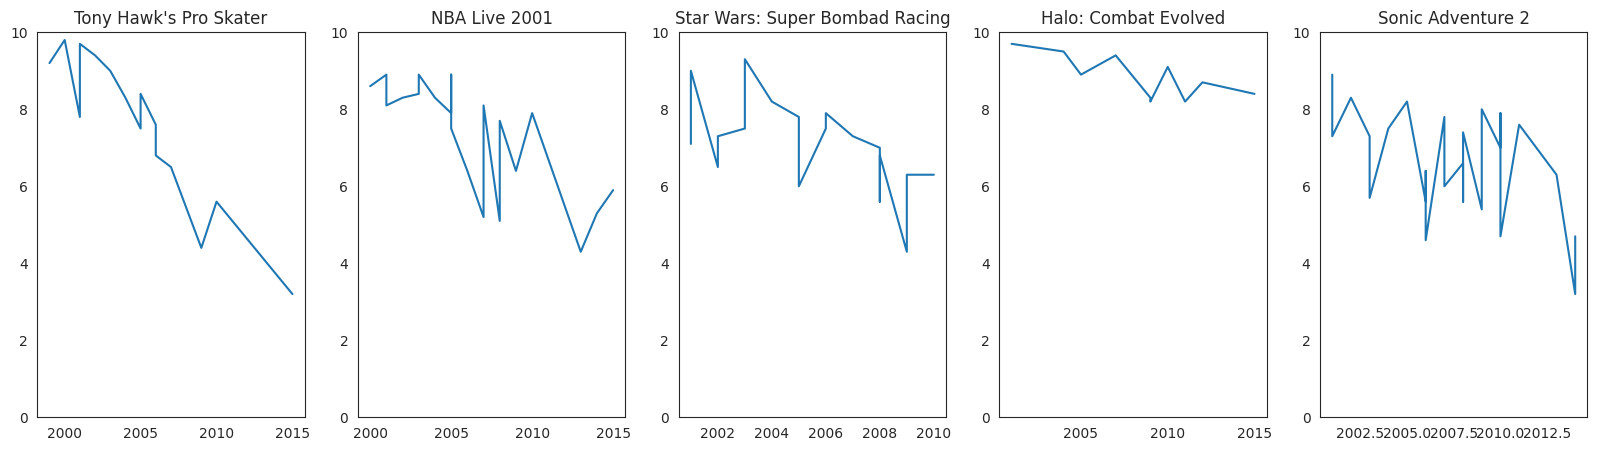

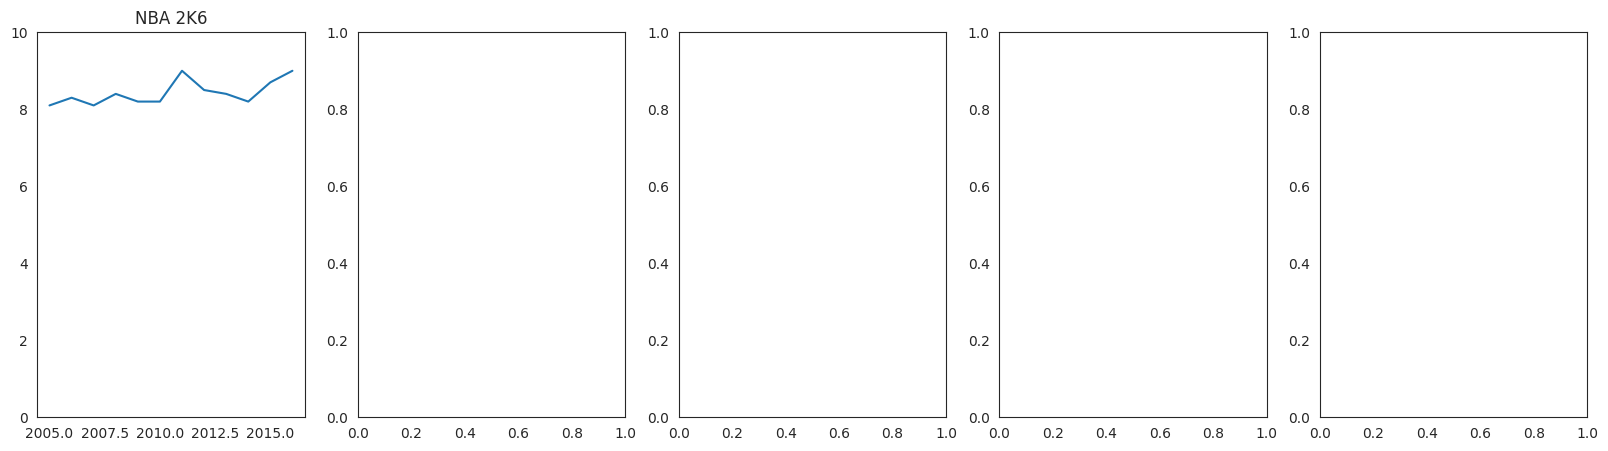

In [45]:
# plot correlated games and their ratings
i = 0
_, ax = plt.subplots(1, σ , figsize=(20, 5))
for k, v in d_critics.items():
    if k in correlated_games_names:
        # make y axis in range [0, 10]
        ax[i].set_ylim([0, 10])
        ax[i].plot(v[1], v[0])
        ax[i].set_title(k)
        i += 1
        if i % σ == 0:
            plt.show()
            _, ax = plt.subplots(1, σ , figsize=(20, 5))
            i = 0
            


7


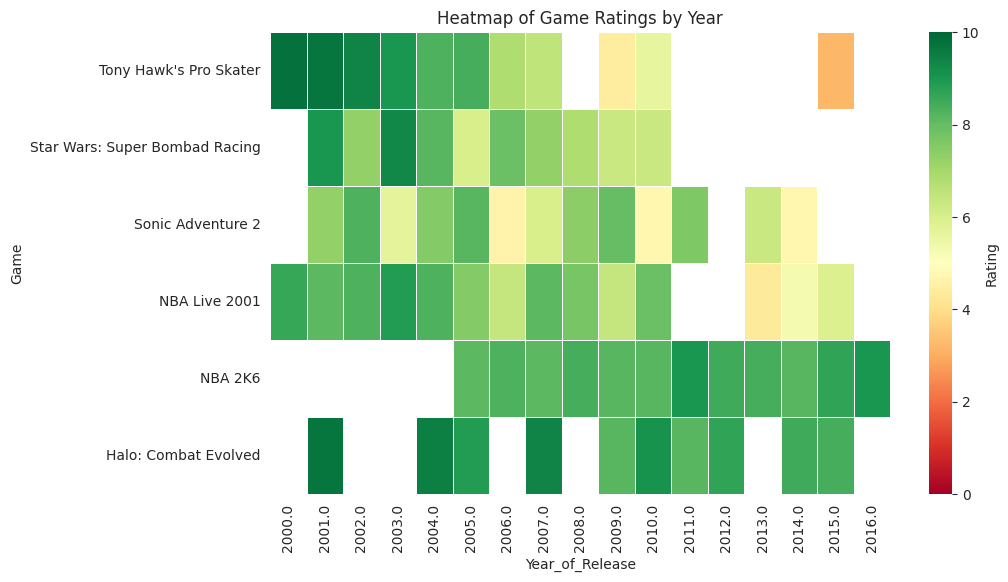

7


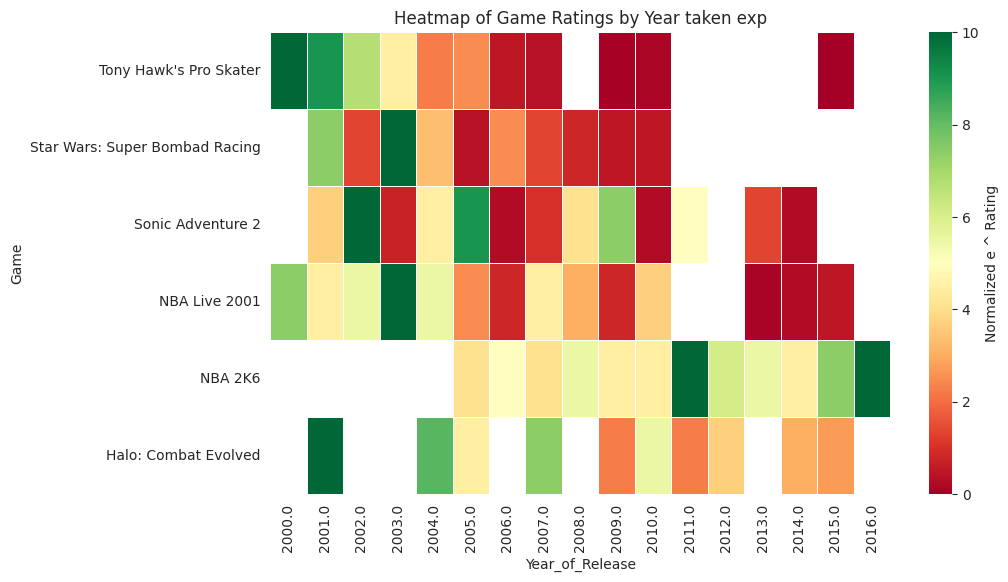

In [46]:
# plot correlated games and their ratings (heatmap)
df_year_rate_critics5 = df_year_rate_critics2.copy()
# take years from 2000 to 2016
df_year_rate_critics5 = df_year_rate_critics5.loc[df_year_rate_critics5['Year_of_Release'] >= 2000]
df_year_rate_critics5 = df_year_rate_critics5[['Year_of_Release', *correlated_games_names]]

plot_heatmap_melted(df_year_rate_critics5, minimum=0, maximum=10, label='Rating', exp=False)
plot_heatmap_melted(df_year_rate_critics5, minimum=0, maximum=10, label='Normalized e ^ Rating', exp=True)


We see that only few games (13% of the games) have a correlation (positive or negative) between year of release and user score. And thus, we can't reject the null hypothesis. This means that there is no correlation between year of release and user score for a most games.

# Hypothesis testing 2
### Null Hypothesis: 
        Average user score for a specific game is the same for all versions (does not increase or decrease over time)

### Alternative Hypothesis:
        Average user score for a specific game is different for different versions (increases or decreases over time)
        


In [47]:
# for each year, compute the average rating
# user score
df_year_rate7 = df_year_rate2.copy()
# filter out games having less than θ versions
df_year_rate7 = df_year_rate7.loc[:, df_year_rate7.count() >= θ]
print(df_year_rate7.shape)
# take years from 2000 to 2016
df_year_rate7 = df_year_rate7.loc[df_year_rate7['Year_of_Release'] >= 2000]
# compute average rating for each year
df_year_rate7_g = df_year_rate7.groupby('Year_of_Release')
year_avg_rate = pd.DataFrame(columns=['Year_of_Release', 'Average'])

for _, g in df_year_rate7_g:    
    year_avg_rate = pd.concat([year_avg_rate, pd.DataFrame({'Year_of_Release': g['Year_of_Release'].iloc[0], 'Average': g.iloc[:,1:].mean().mean()}, index=[0])], ignore_index=True)
year_avg_rate['Year_of_Release'] = year_avg_rate['Year_of_Release'].astype(int)
year_avg_rate = year_avg_rate.sort_values(by='Year_of_Release')
year_avg_rate = year_avg_rate.set_index('Year_of_Release')
year_avg_rate



(25, 33)


,Average
Year_of_Release,
2000,7.725000
2001,8.021053
2002,8.086957
2003,7.909091
2004,7.681481
2005,8.181481
2006,7.532143
2007,7.157143
2008,7.600000


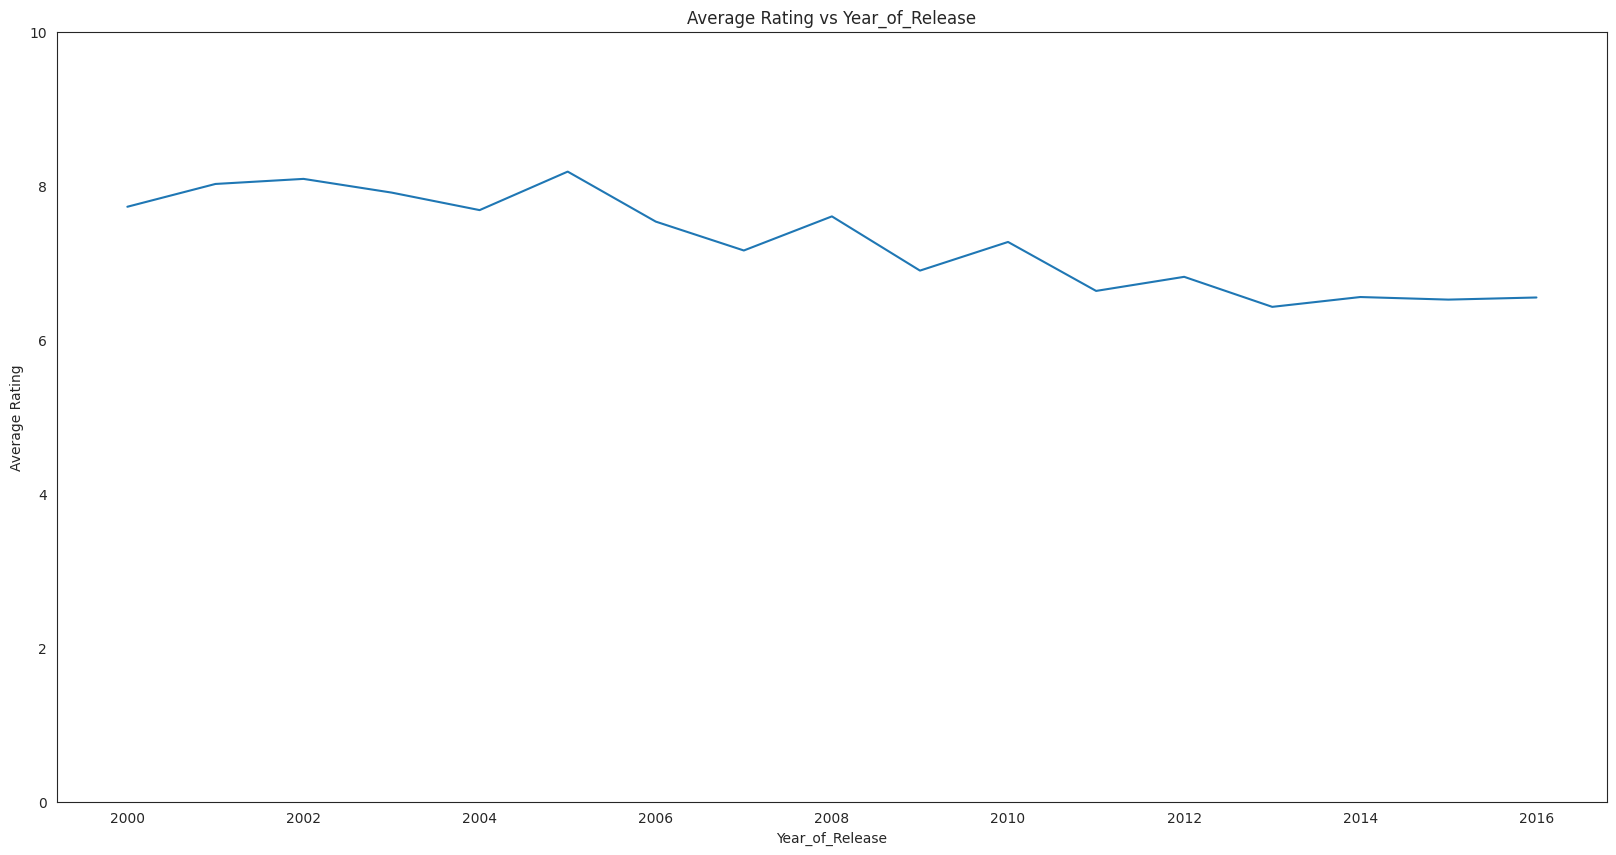

In [48]:
# plot average rating vs year of release
plt.figure(figsize=(20, 10))
# make plot y axis in range [0, 10]
plt.ylim([0, 10])

plt.plot(year_avg_rate.index, year_avg_rate['Average'])
plt.xlabel('Year_of_Release')
plt.ylabel('Average Rating')
plt.title('Average Rating vs Year_of_Release')
plt.show()

2


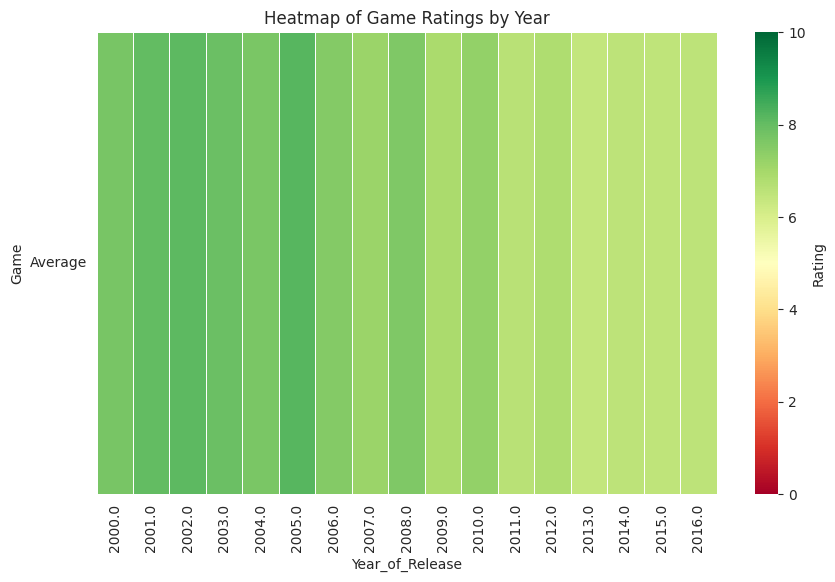

2


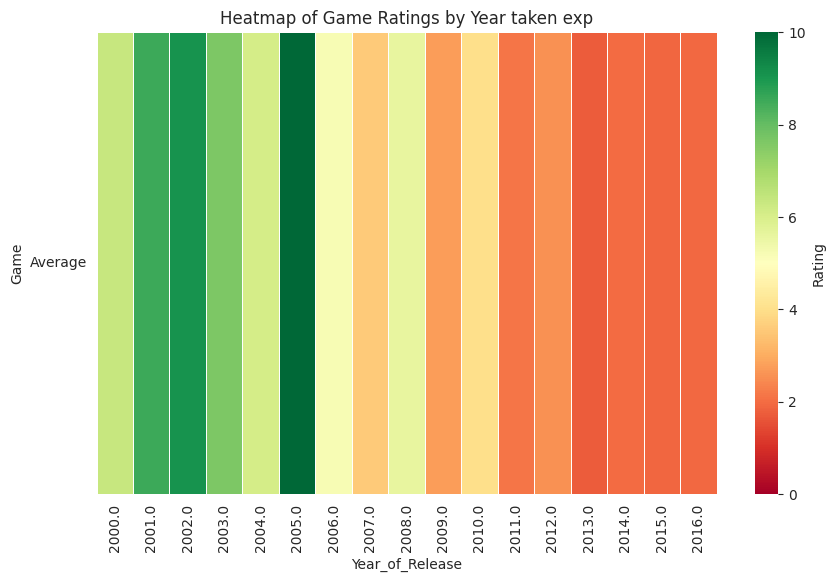

In [49]:
# convert Year_of_Release from index to column
year_avg_rate2 = year_avg_rate.copy()
year_avg_rate2['Year_of_Release'] = year_avg_rate2.index.astype(float)
# make it first column
cols = year_avg_rate2.columns.tolist()
cols = cols[-1:] + cols[:-1]
year_avg_rate2 = year_avg_rate2[cols]

plot_heatmap_melted(year_avg_rate2, minimum=0, maximum=10, label='Rating', exp=False)
plot_heatmap_melted(year_avg_rate2, minimum=0, maximum=10, label='Rating', exp=True)

In [50]:
# test the hypothesis that for each year, if we take average rating, this average is increasing or decreasing
seq = year_avg_rate['Average'].tolist()
seq

[7.725,
 8.021052631578947,
 8.08695652173913,
 7.909090909090909,
 7.68148148148148,
 8.181481481481482,
 7.5321428571428575,
 7.157142857142857,
 7.6,
 6.895833333333333,
 7.267857142857143,
 6.632000000000001,
 6.815,
 6.425,
 6.552631578947368,
 6.519047619047619,
 6.546666666666666]

In [55]:
# test if the sequence is increasing or decreasing
# null hypothesis: the sequence is not increasing or decreasing
# alternative hypothesis: the sequence is increasing or decreasing
import scipy.stats as stats
corr, p = stats.pearsonr(seq, list(range(len(seq))))
print('Correlation: ', corr, 'p-value: ', p)

Correlation:  -0.910934677505676 p-value:  3.751674022337818e-07


    We see that the correlation coefficient is -0.91 and that p-value is almost 0. This means that we can reject the null hypothesis and accept the alternative hypothesis. This means that average user score for a specific game is different for different versions (increases or decreases over time).

---------------------------------

## 3- Comparing Expectations to data:
        We see that only few games (13% of the games) have a correlation (positive or negative) between year of release and user score. And thus, we can't reject the null hypothesis. This means that there is no correlation between year of release and user score for most games.
